#Deep learning : ISF project

## Packages

In [360]:
#numpy + matplotlib
% pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [361]:
!pip install missingno
import missingno

In [393]:
import seaborn as sns
import pandas as pd
import statsmodels.api

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

#1. Data importation

**Subsections** :

- Importation from Github repository

- Check for data types

- Split categorical/numerical

- Data dimensions

In [316]:
data = pd.read_csv("https://raw.githubusercontent.com/louis75020/Deep_learning_M2/Linear_model/credit_immobilier_ISF.csv")
data.head()

,compte_courant,duree_emprunt_mois,historique_credit,raison,montant,compte_epargne,duree_emploi,annees_presence_logement,age,autre_credit,logement,nbre_emprunts_actuels,job,dependants,telephone,defaillant,revenufinal
0,< 0 Euro,6,critique,ameublement,1169,inconnu,> 7 annees,4.0,67.0,aucun,proprietaire,2,qualifie,1,oui,non,8135.110140
1,1 - 200 Euro,48,bon,ameublement,5951,< 100 Euro,1 - 4 annees,2.0,22.0,aucun,proprietaire,1,qualifie,1,oui,oui,19334.307686
2,inconnu,12,critique,education,2096,< 100 Euro,4 - 7 annees,3.0,49.0,aucun,proprietaire,1,non_qualifie,2,oui,non,4864.954258
3,< 0 Euro,42,bon,ameublement,7882,< 100 Euro,4 - 7 annees,4.0,45.0,aucun,autre,1,qualifie,2,oui,non,22152.947349
4,< 0 Euro,24,pauvre,auto,4870,< 100 Euro,1 - 4 annees,4.0,53.0,aucun,autre,2,qualifie,2,oui,oui,23900.704144


Notes :

- inconnu for compte_courant = NAN

- snake case for column names ok

- unstandardized categorical data

Let's check data types

In [317]:
data.dtypes

compte_courant               object
duree_emprunt_mois            int64
historique_credit            object
raison                       object
montant                       int64
compte_epargne               object
duree_emploi                 object
annees_presence_logement    float64
age                         float64
autre_credit                 object
logement                     object
nbre_emprunts_actuels         int64
job                          object
dependants                   object
telephone                    object
defaillant                   object
revenufinal                 float64
dtype: object

Let's get categorical data names.

In [318]:
types = data.dtypes == 'object'
categorical = list(data.columns[types])
categorical

['compte_courant',
 'historique_credit',
 'raison',
 'compte_epargne',
 'duree_emploi',
 'autre_credit',
 'logement',
 'job',
 'dependants',
 'telephone',
 'defaillant']

In [319]:
numerical = list(data.columns)
for x in categorical : numerical.remove(x)

Check for data dimensions :

In [320]:
data.shape

(1021, 17)

# 2. Univariate analysis

We won't deal with missing values at this point (we'll just count them) :

Our analysis must be objective. No model or feature engineering should be performed at this point to avoid fake statistical tests/descriptive statistics. That's why the replacement of missing values has to be performed later.

**Executive summary**

- Descriptive statistics

- Distributions : density/histogram/cdf/qqplot for numerical variables, histograms for categorical variables

Rk: We do qq-plots ONLY because we already know that we will use linear models. In practice, we do not care.

## Descriptive statistics

**Numerical**

In [96]:
data[numerical].describe()

,duree_emprunt_mois,montant,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,1021.000000,1021.000000,1018.000000,1020.000000,1021.000000,1021.000000
mean,20.770813,3250.088149,2.844794,35.491176,1.409403,12273.073874
std,12.050318,2830.788792,1.104864,11.395078,0.576390,11200.509536
min,4.000000,250.000000,1.000000,19.000000,1.000000,734.476054
25%,12.000000,1352.000000,2.000000,27.000000,1.000000,5192.478646
50%,18.000000,2299.000000,3.000000,33.000000,1.000000,8615.582896
75%,24.000000,3966.000000,4.000000,42.000000,2.000000,15559.590686
max,72.000000,18424.000000,4.000000,75.000000,4.000000,79354.527366


- 3 missing values for annees_presence_logement, 1 for age.

- annees_presence_logement/nbre_emprunts_actuels could be treated as categorical. It has a sense to introduce distance between these variables but they take only a few different values.

- Most of variables are right-skewed

**Categorical**

In [97]:
data[categorical].describe()

,compte_courant,historique_credit,raison,compte_epargne,duree_emploi,autre_credit,logement,job,dependants,telephone,defaillant
count,1021,1021,1021,1020,1021,1021,1021,1018,1021,1021,1020
unique,4,5,6,5,6,4,4,5,3,1,2
top,inconnu,bon,ameublement,< 100 Euro,1 - 4 annees,aucun,proprietaire,qualifie,1,oui,non
freq,402,535,486,611,349,834,731,648,864,1021,717


- 1 missing value for compte_epargne, 3 for job, 1 for defaillant

- telephone to drop out (only 1 unique value)

- inconnu for compte_courant could be treated as a missing value but, we'll treat it as a modality for compte_courant (otherwise compte_courant should be dropped out).

**NA Visualization**

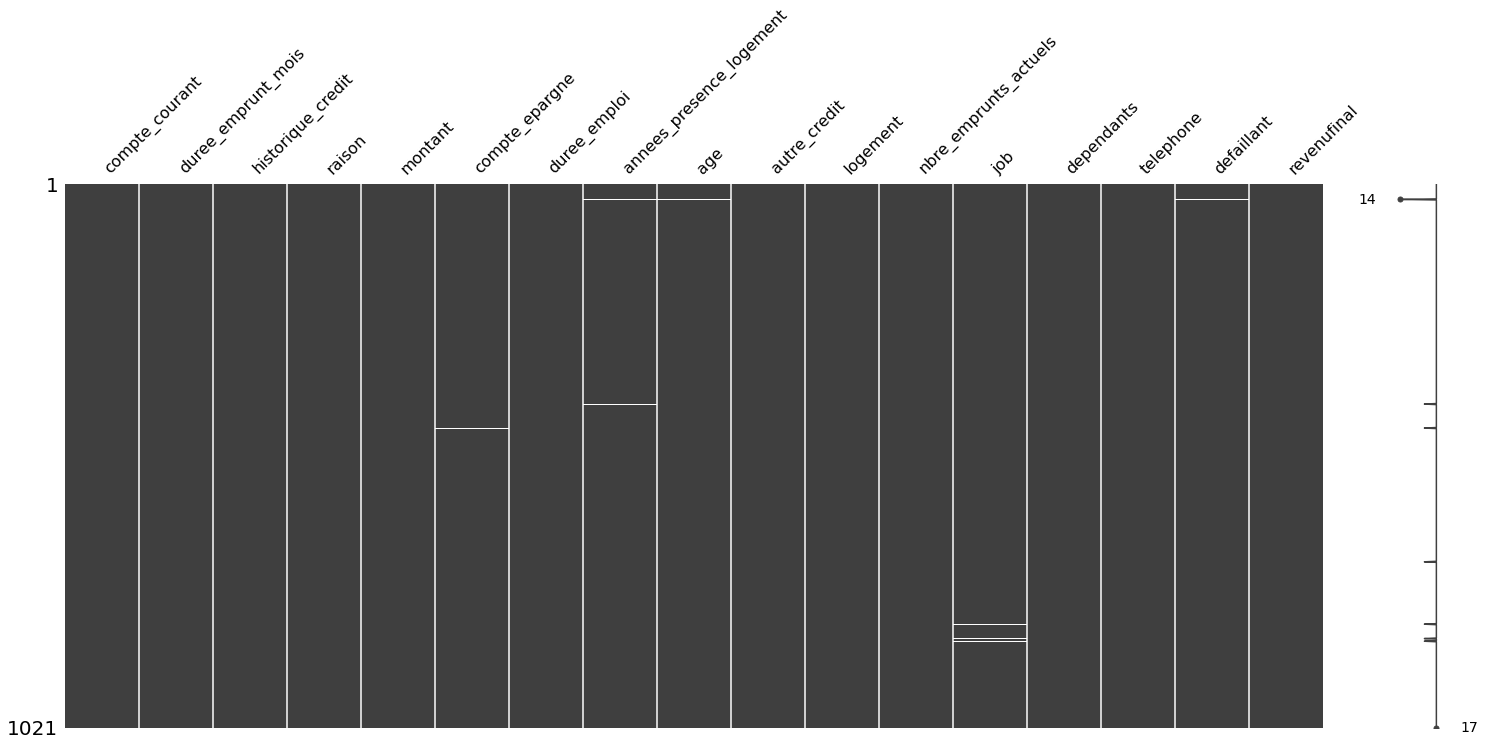

In [98]:
missingno.matrix(data)

1 individual seems to have 3 missing values (wile the other ones have less than 1). Maybe we should drop it to avoid NANs-correlations.

## Distributions

**Categorical**

In [131]:
def hist_plotter(data, x):
  to_plot = data[x].fillna("NAN")
  ax = sns.histplot(to_plot)
  ax.set_xlabel('values', fontsize = 15)
  ax.set_ylabel('count', fontsize = 15)
  title('Histogram of ' + x)

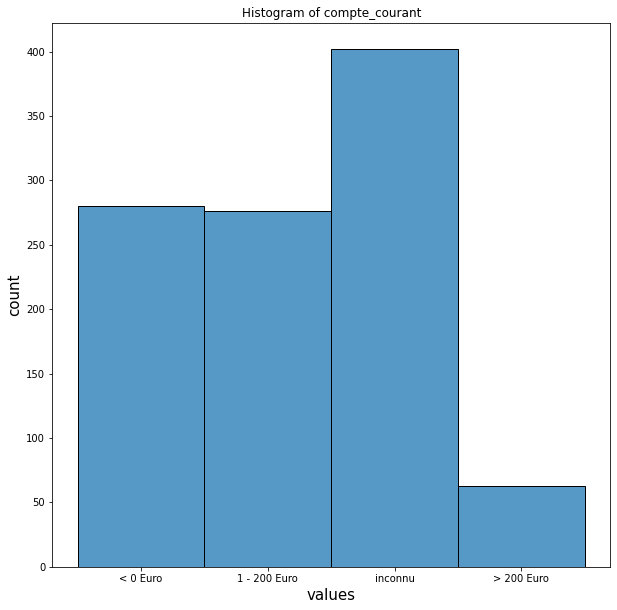

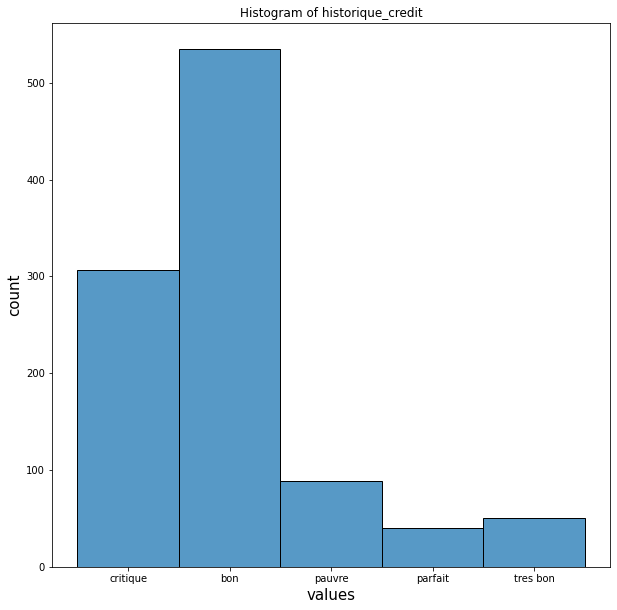

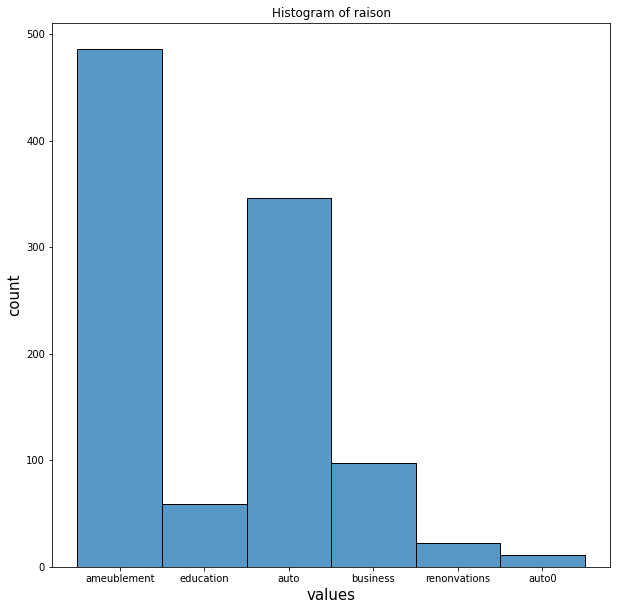

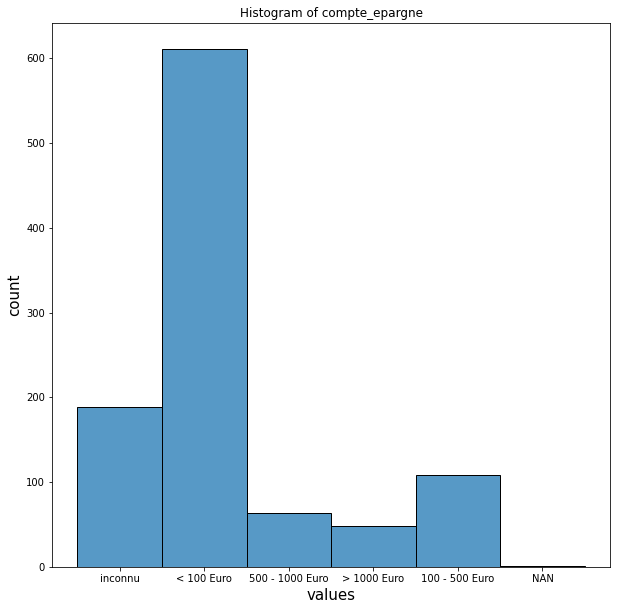

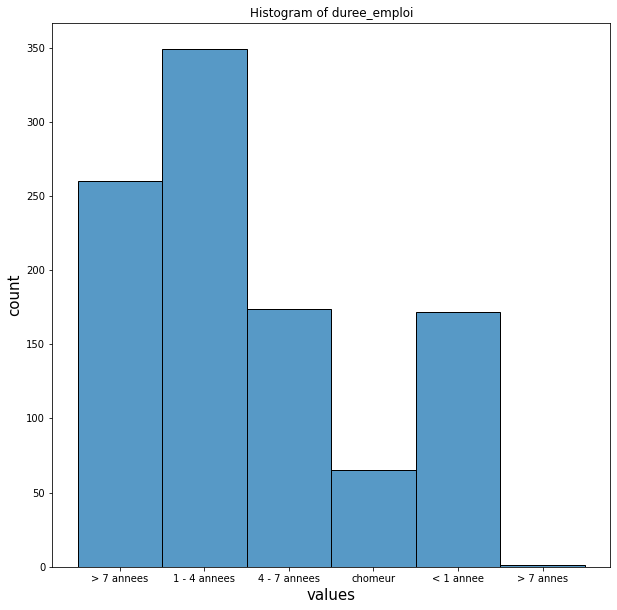

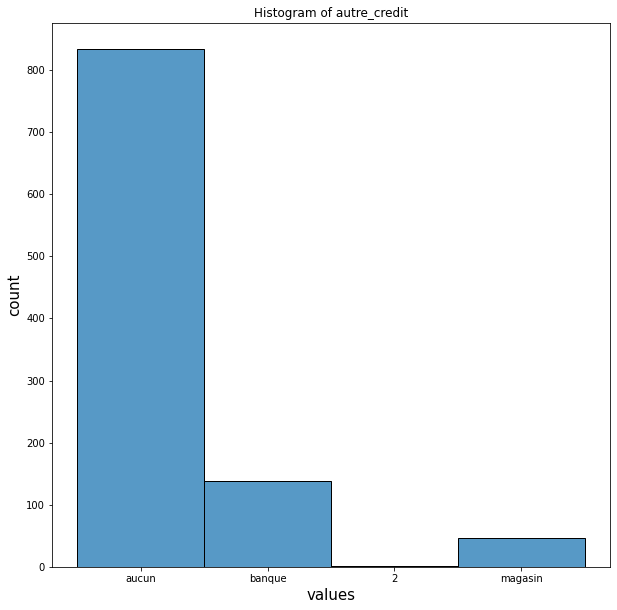

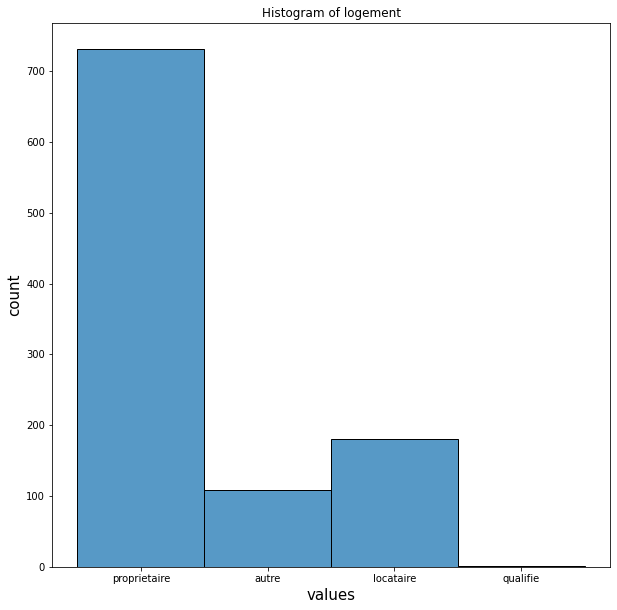

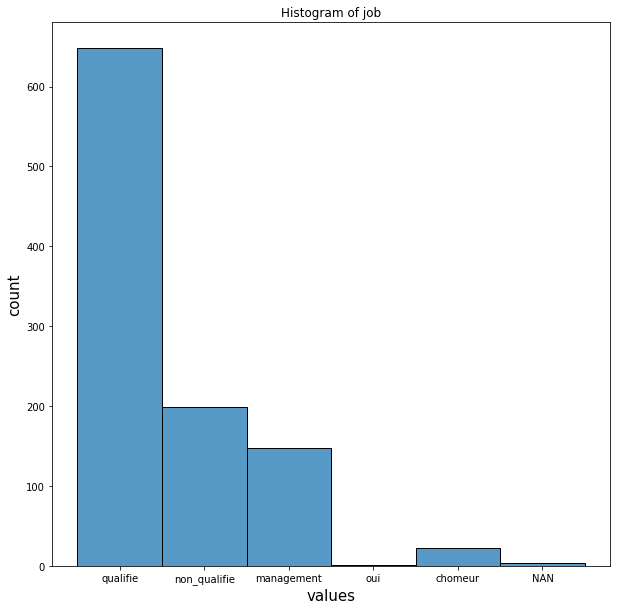

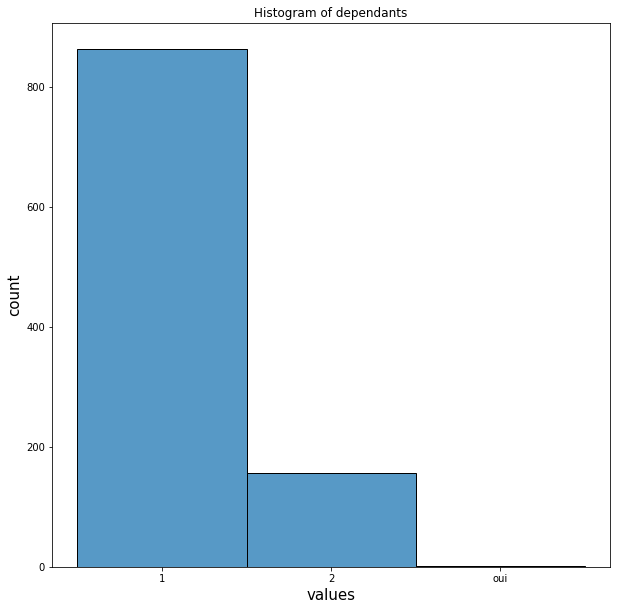

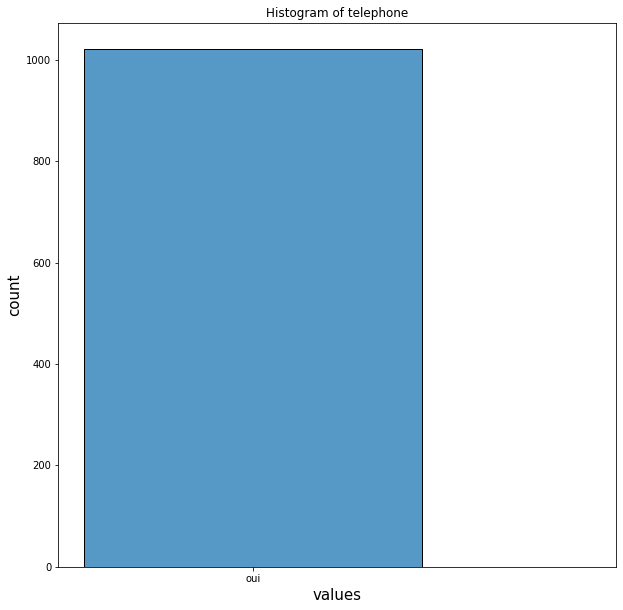

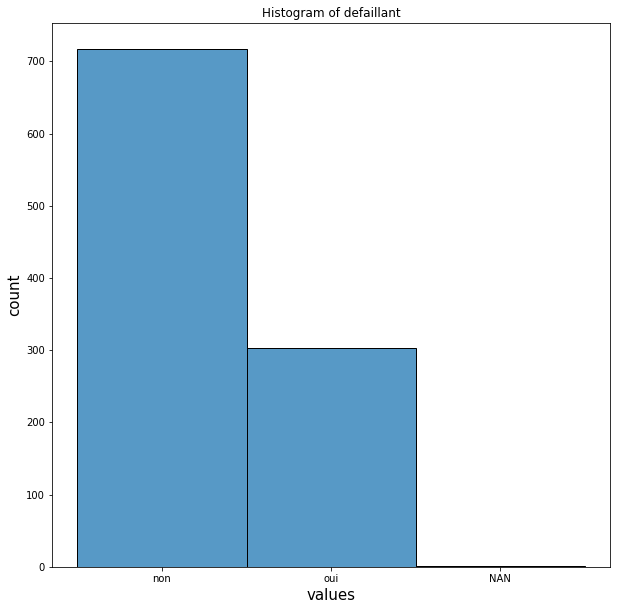

In [132]:
for x in categorical : 
  figure(figsize = (10,10))
  hist_plotter(data, x)
    

- \> 7 annes for duree_emploi is very unfrequent.

- idem for 2 in autre_credit

- idem for 'qualifie' in logment

- idem for oui in job/dependants

In [147]:
def hist_cdf_plotter(data, x) :

  figure(figsize=(20, 20))

  subplot(2,1,1)
  to_plot1 = data[x].fillna("NAN")
  ax1 = sns.distplot(to_plot1)
  ax1.set_xlabel('values')
  ax1.set_ylabel('count')
  title('Histogram of ' + x)
  

  subplot(2,1,2)
  to_plot2 = data[x].dropna()
  ax2 = sns.distplot(to_plot2, hist_kws = dict(cumulative=True), kde_kws = dict(cumulative=True))
  title('CDF of '+ x)
  grid(True)
  xlabel('x values')
  ylabel('P(x<=t)')

  show((ax1, ax2))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


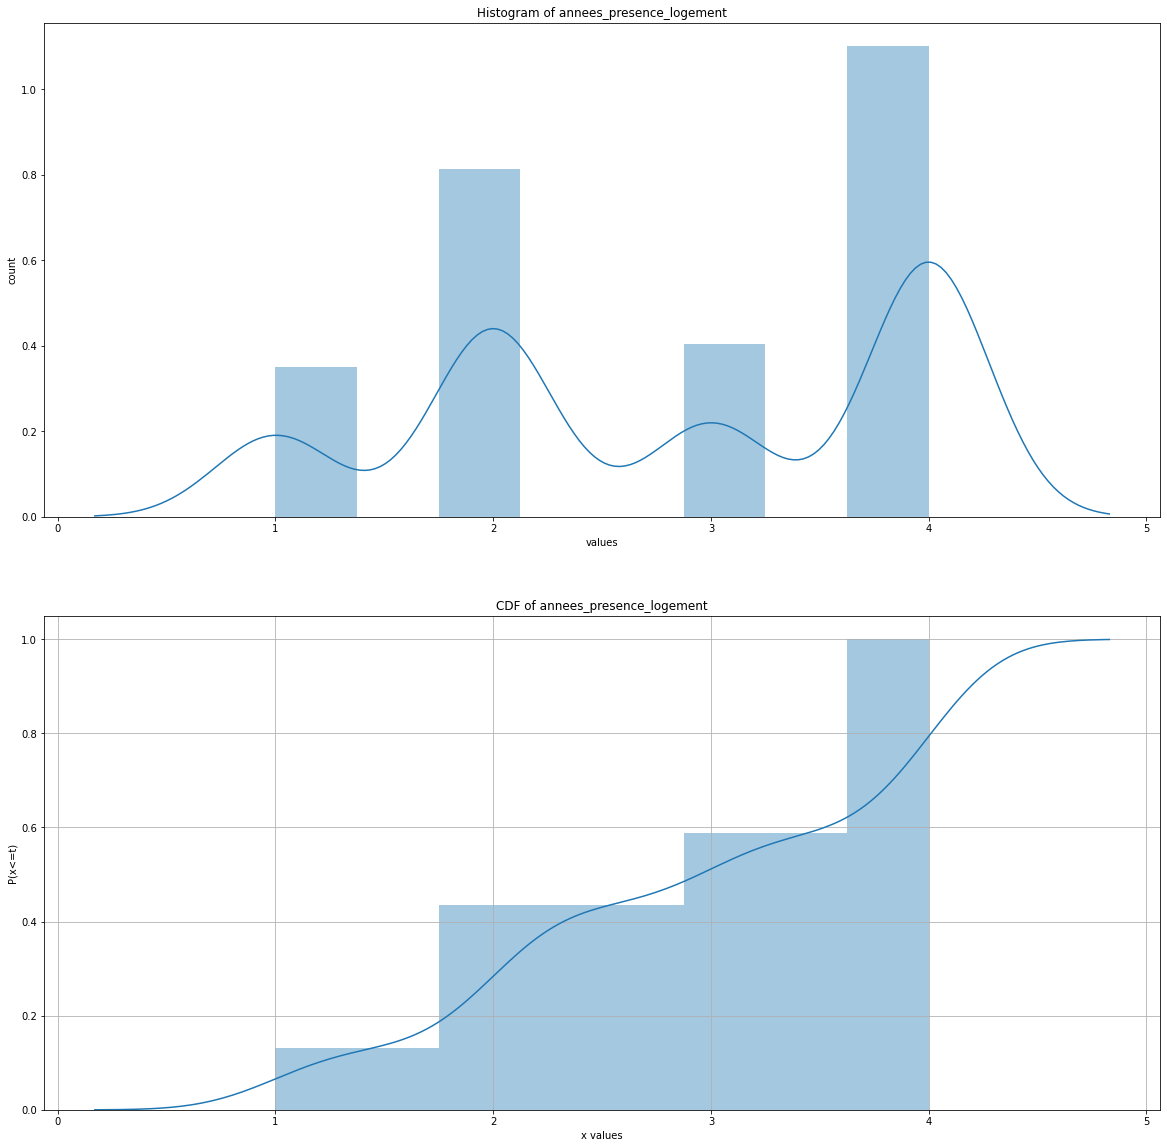

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


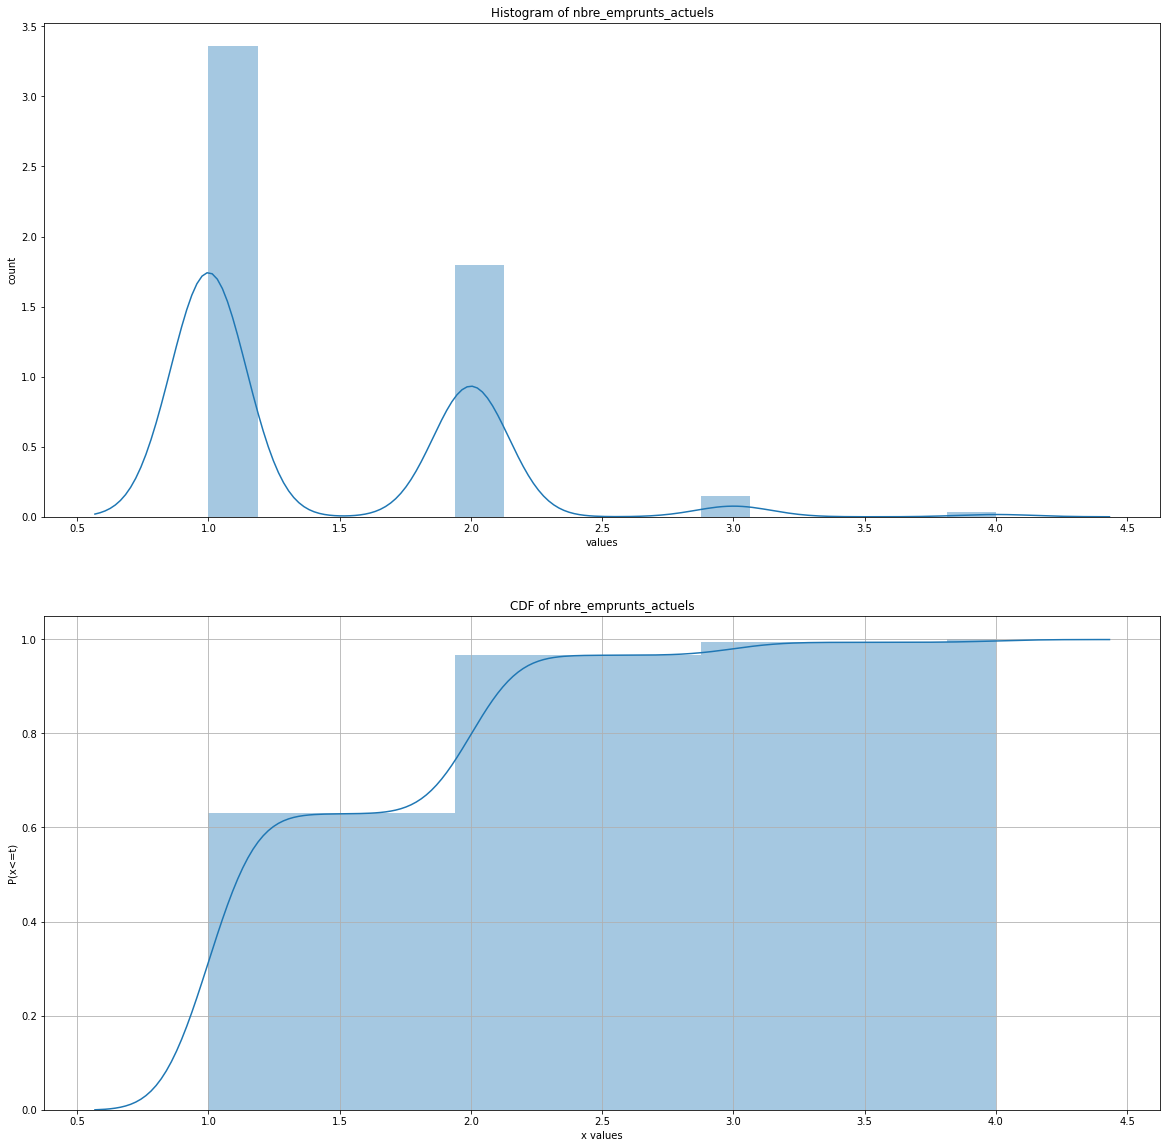

In [148]:
for x in ["annees_presence_logement", "nbre_emprunts_actuels"]:
  hist_cdf_plotter(data, x)

nbre_emprunts_actuels unbalanced

In [173]:
def numerical_plotter(data, x, take_log = False) :

  to_plot = data[x].dropna()

  if take_log : to_plot = log(to_plot)

  figure(figsize = (10,10))
  ax1 = sns.kdeplot(to_plot)
  ax1.set_xlabel('values')
  ax1.set_ylabel('P(X = t)')
  title('Density of ' + x)
  show(ax1)
  

  figure(figsize = (10,10))
  ax2 = sns.kdeplot(to_plot, cumulative = True)
  title('CDF of '+ x)
  grid(True)
  xlabel('x values')
  ylabel('P(x<=t)')
  show(ax2)

  figure(figsize = (10,10))
  statsmodels.api.qqplot(to_plot, fit = True) #default dist : norm
  title("qqplot of " + x)
  show()

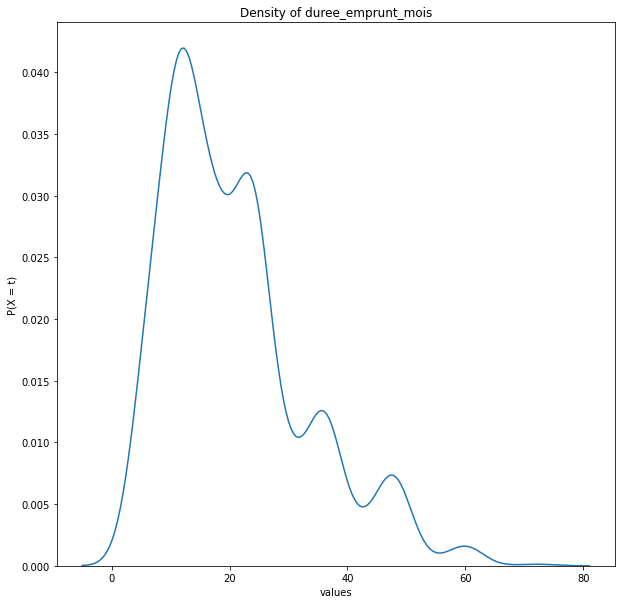

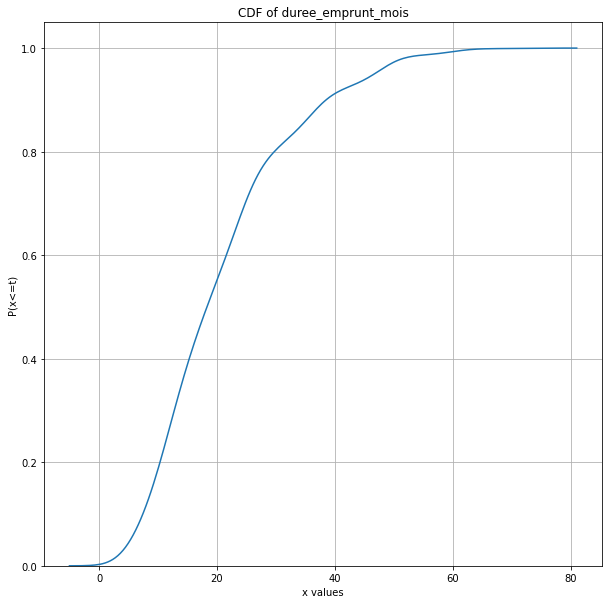

<Figure size 720x720 with 0 Axes>

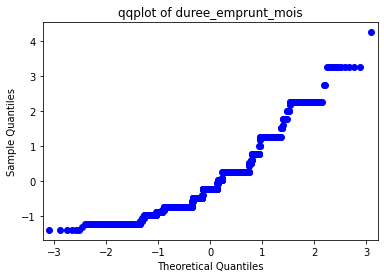

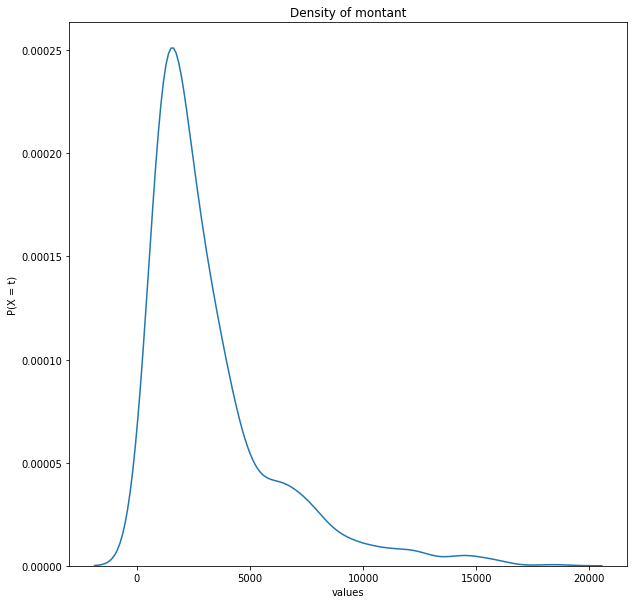

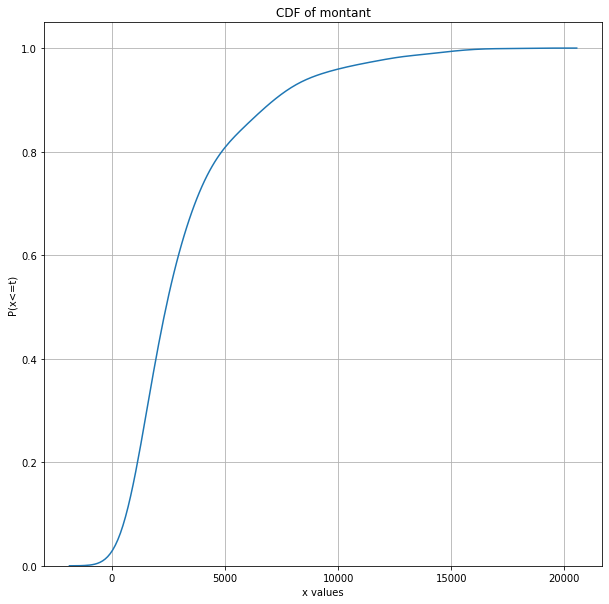

<Figure size 720x720 with 0 Axes>

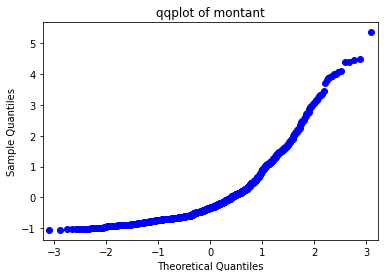

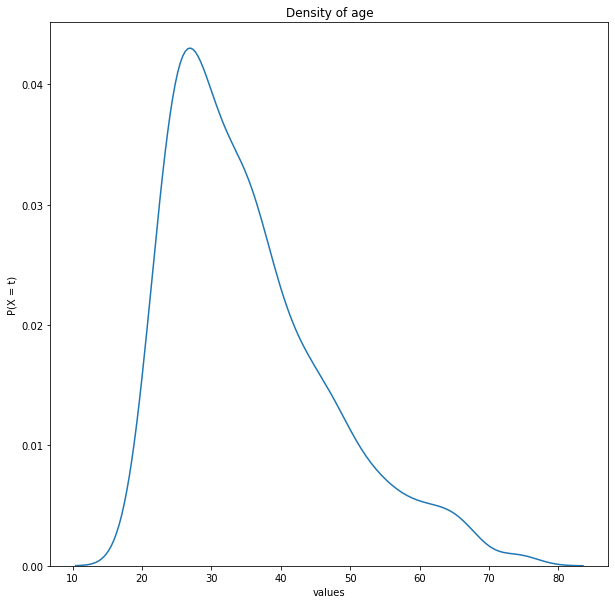

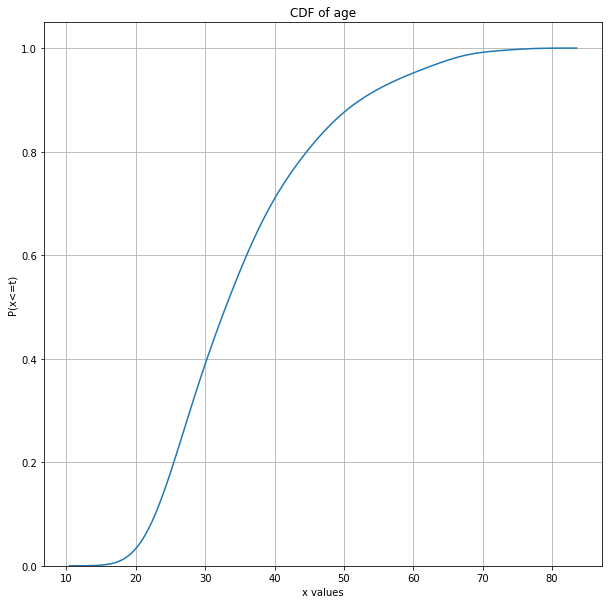

<Figure size 720x720 with 0 Axes>

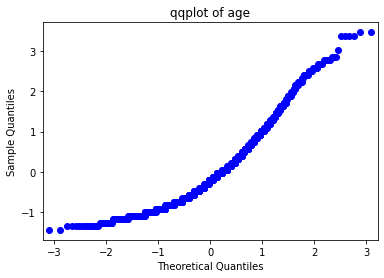

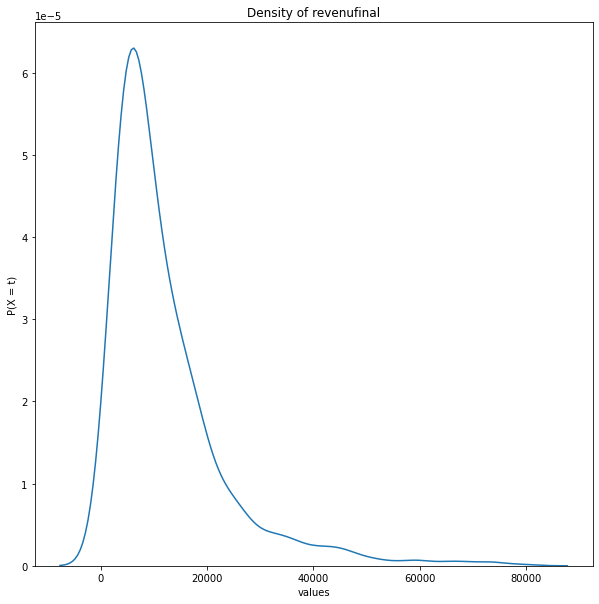

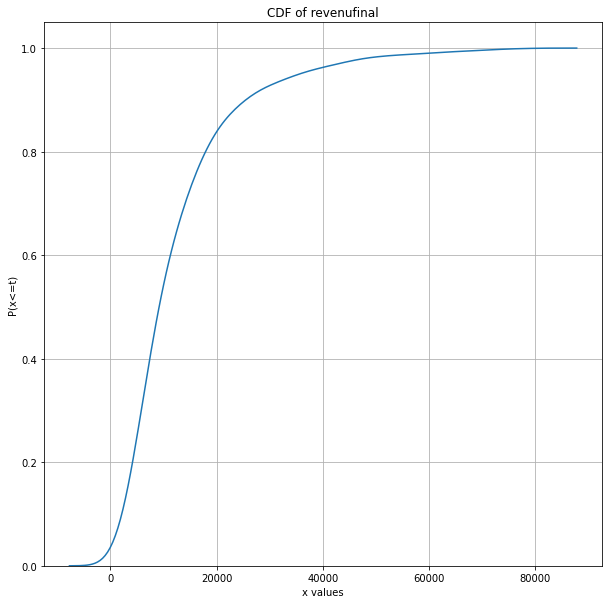

<Figure size 720x720 with 0 Axes>

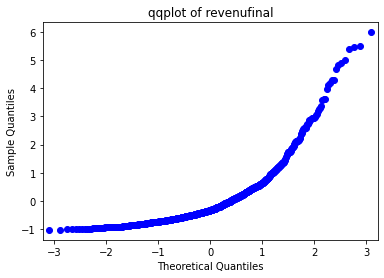

In [174]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels"]: continue
  numerical_plotter(data, x)

Only skewed-gaussians.

To take it gaussians we would need to take the log.

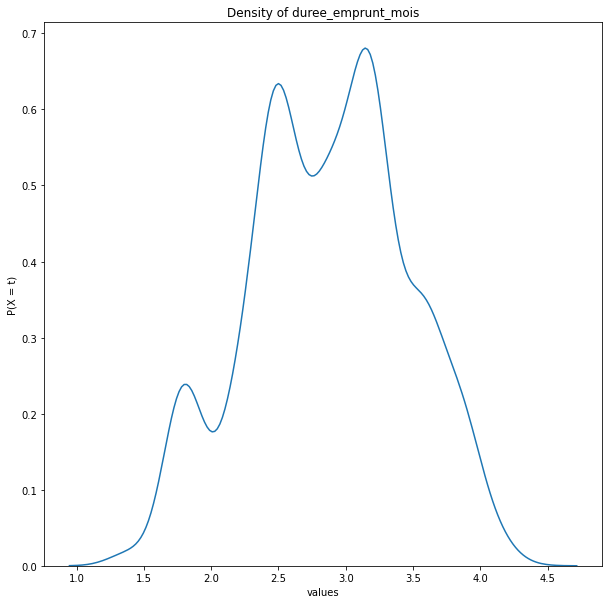

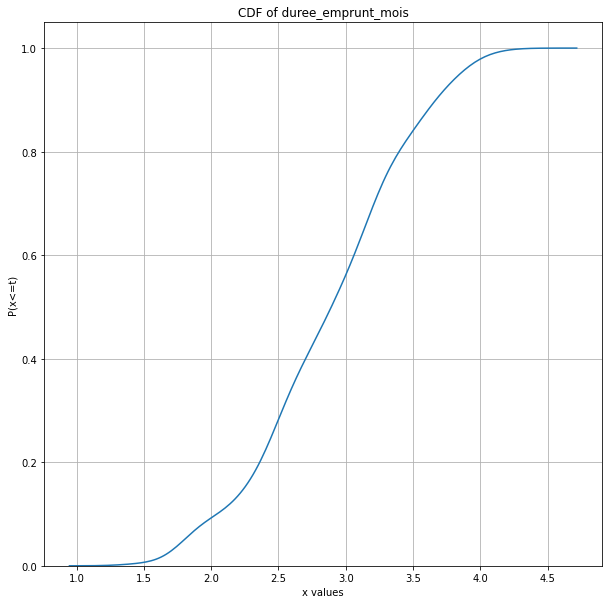

<Figure size 720x720 with 0 Axes>

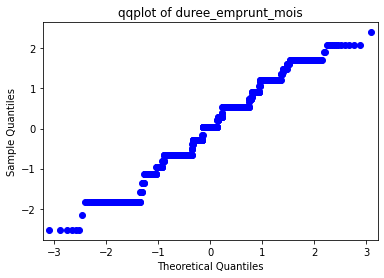

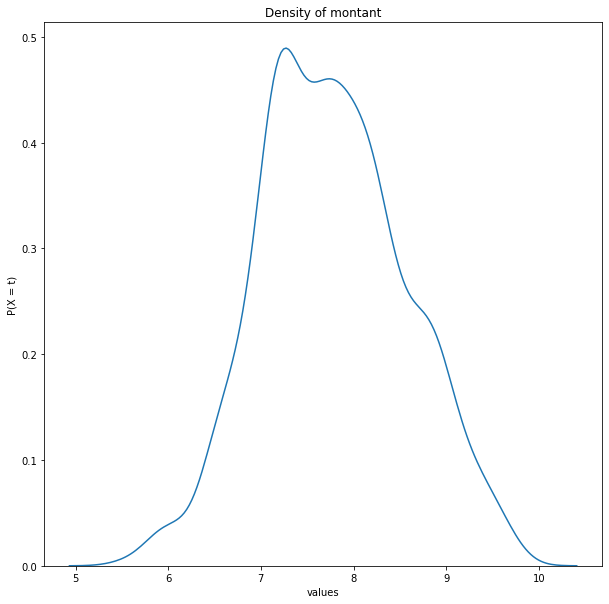

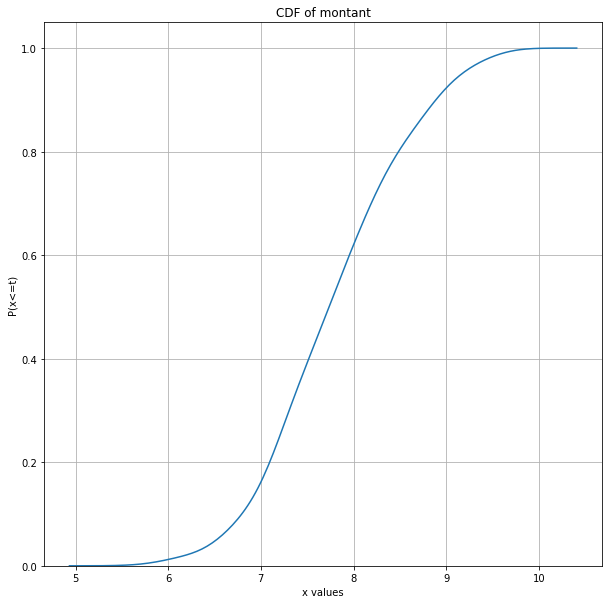

<Figure size 720x720 with 0 Axes>

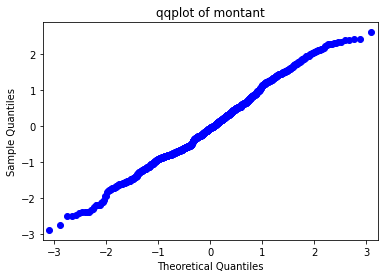

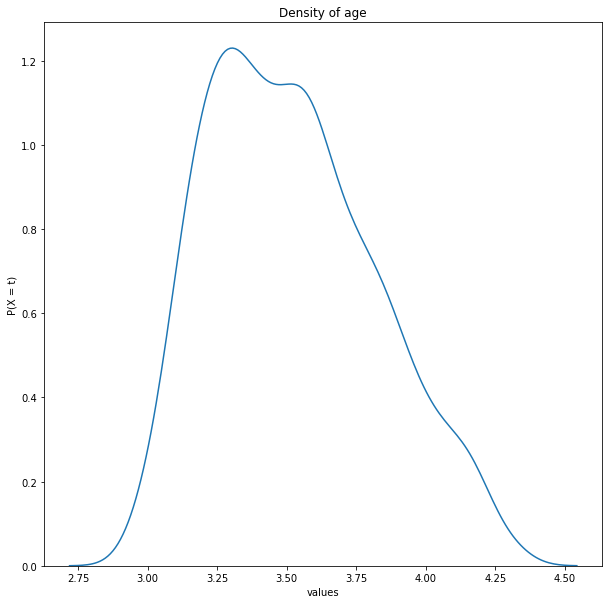

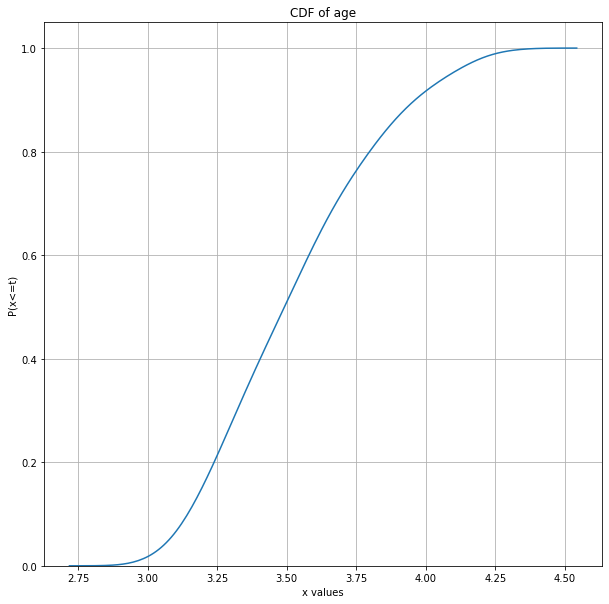

<Figure size 720x720 with 0 Axes>

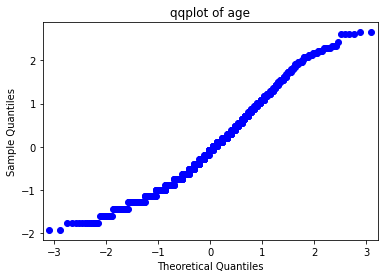

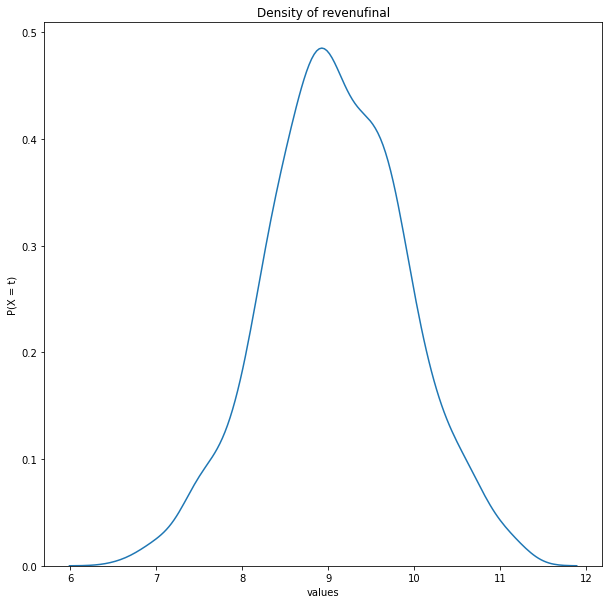

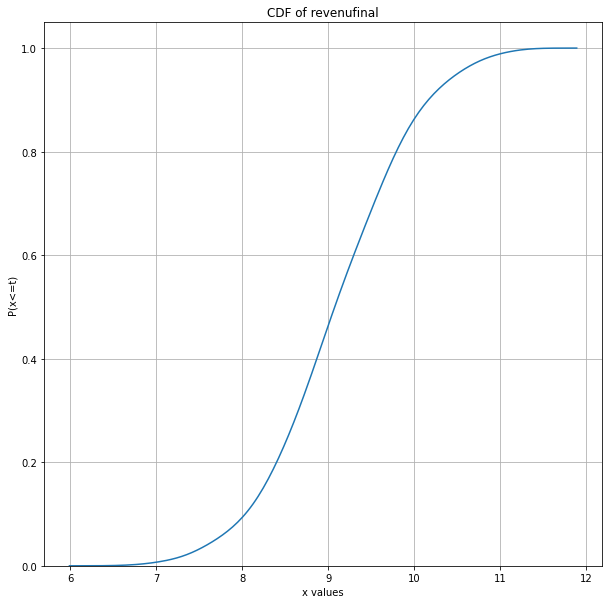

<Figure size 720x720 with 0 Axes>

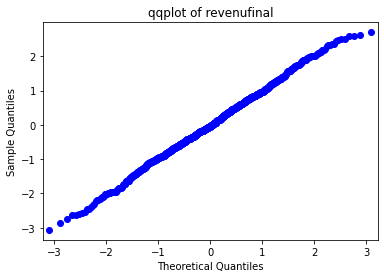

In [175]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels"]: continue
  numerical_plotter(data, x, take_log = True)

#3. Multivariate Analysis



**Executive summary**

-Pearson's correlation plots (ok because we will perform a linear model so we do not need a copule).

-Joint distributions (boxplots/conditionnal densities for target vs categorical / countours for target vs  numerical).

## Categorical

In [202]:
def target_vs_categorical(data, target, x) : 
    
    Xy = pd.DataFrame( (data[x], data[target]) ).transpose()

    print("#############Response vs " + x + "##############")

    print("_____________Pivot_______________")
    figsize = (10, 10)
    # Plot the orbital period with horizontal boxes
    sns.boxplot(x = x, 
                y = target, 
                data=Xy,
                whis=[0, 100], 
                width=.6, 
                palette="vlag")

    # Add in points to show each observation
    sns.stripplot(x = x, 
                  y = target, 
                  data=Xy,
                  size=4, 
                  color=".3", 
                  linewidth=0)
    show()

    print("______________Conditionnal Distribution_______________")
    figsize = (10, 10)
    try : 
      Xy[x] = Label_Encoder().fit_transform(Xy[x])
      sns.displot(x = target, hue = x, data = Xy, kde = True, fill = True)
      show()
    except : 
      sns.displot(Xy, x = target, hue = x, fill = True)
      show()

#############Response vs compte_courant##############
_____________Pivot_______________


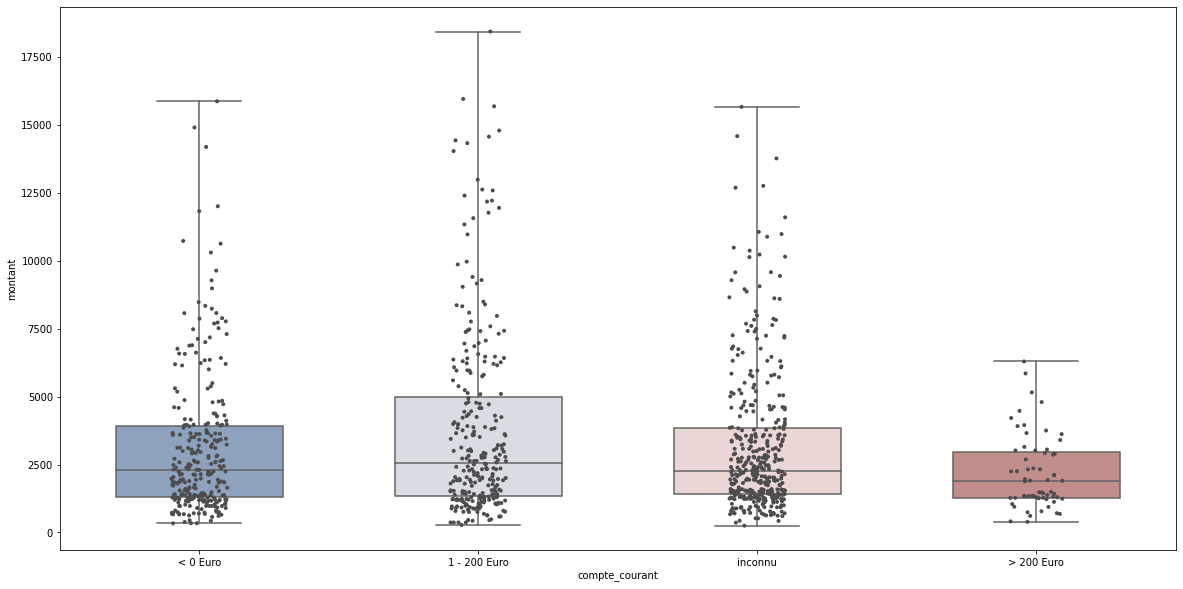

______________Conditionnal Distribution_______________


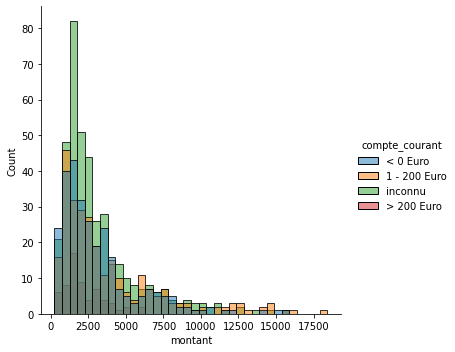

#############Response vs historique_credit##############
_____________Pivot_______________


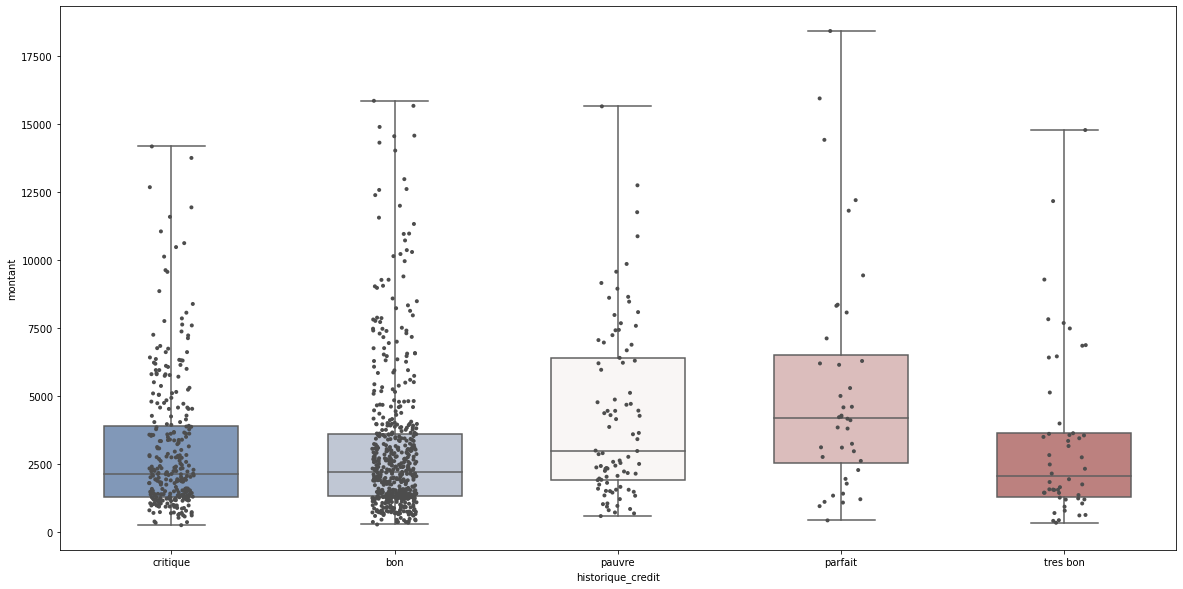

______________Conditionnal Distribution_______________


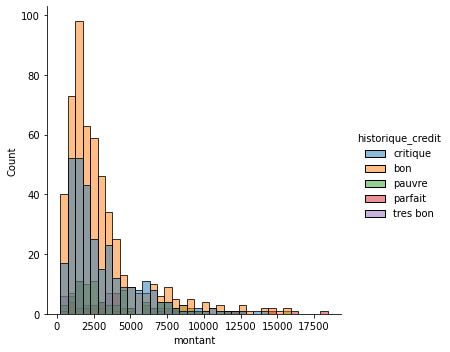

#############Response vs raison##############
_____________Pivot_______________


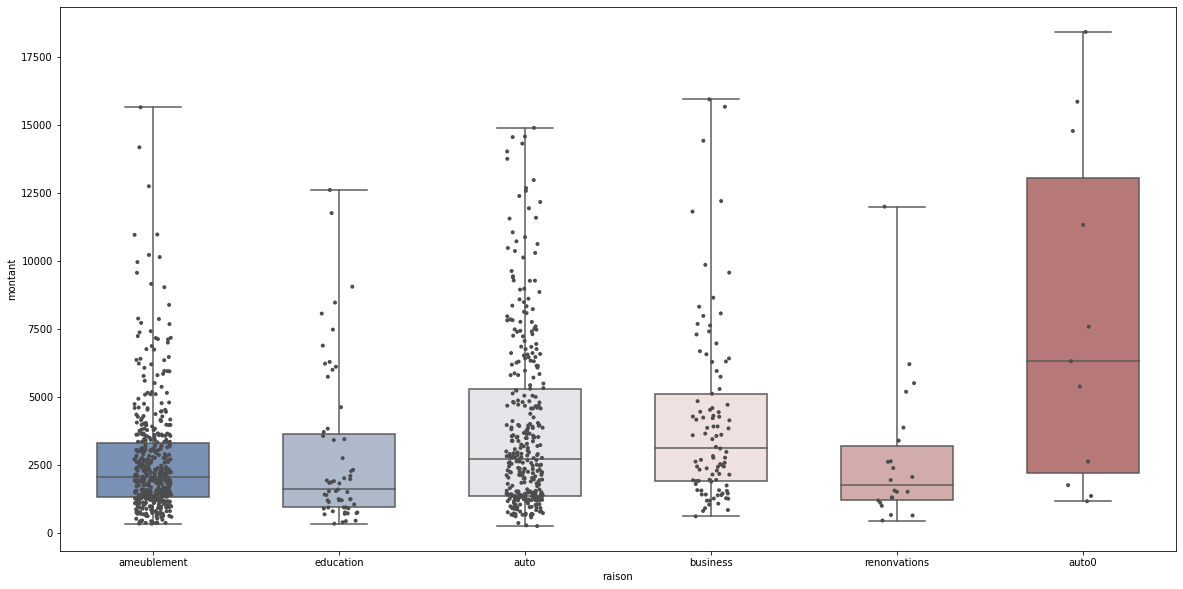

______________Conditionnal Distribution_______________


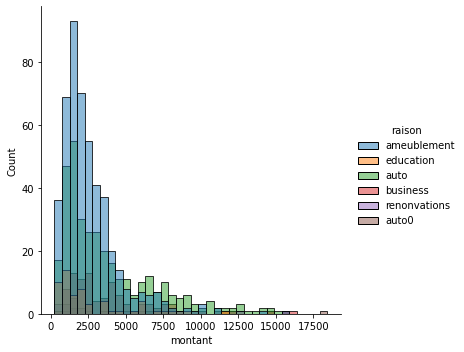

#############Response vs compte_epargne##############
_____________Pivot_______________


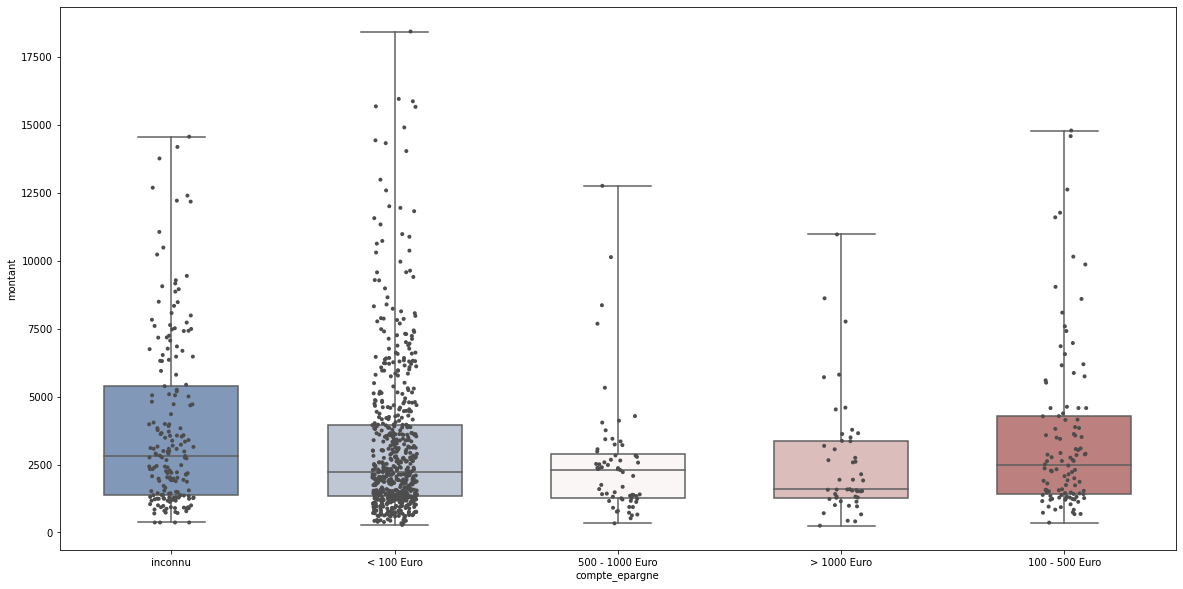

______________Conditionnal Distribution_______________


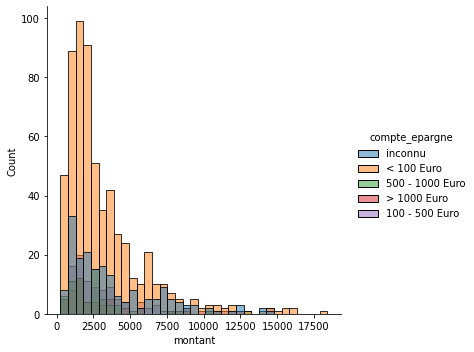

#############Response vs duree_emploi##############
_____________Pivot_______________


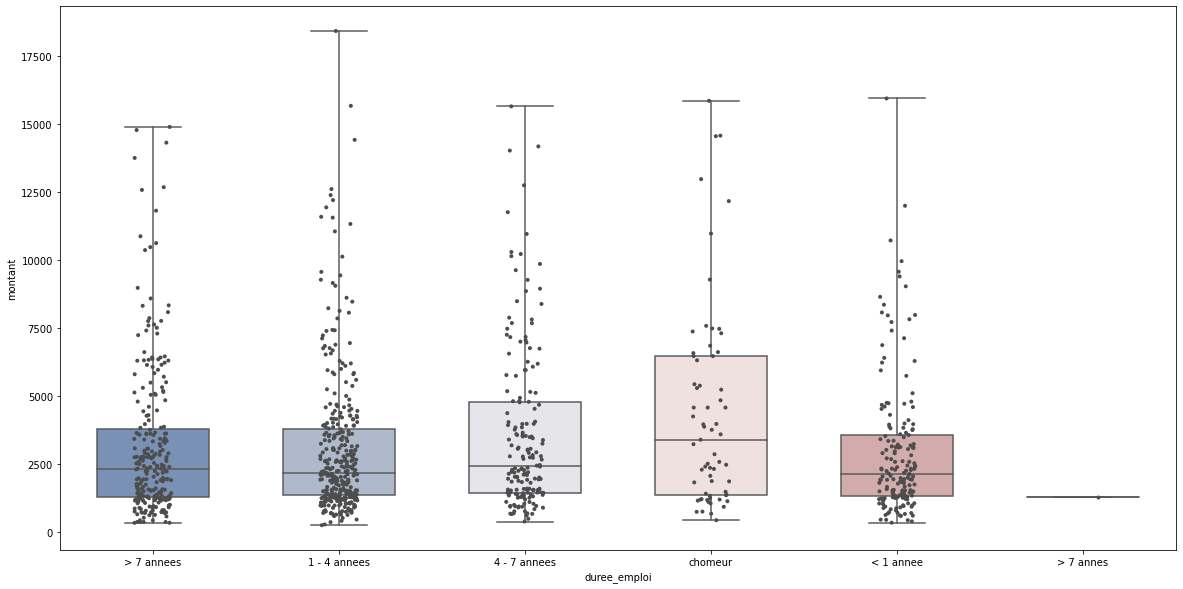

______________Conditionnal Distribution_______________


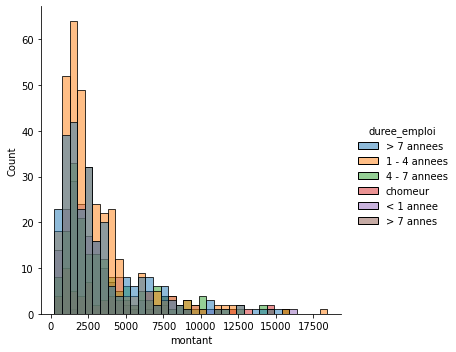

#############Response vs autre_credit##############
_____________Pivot_______________


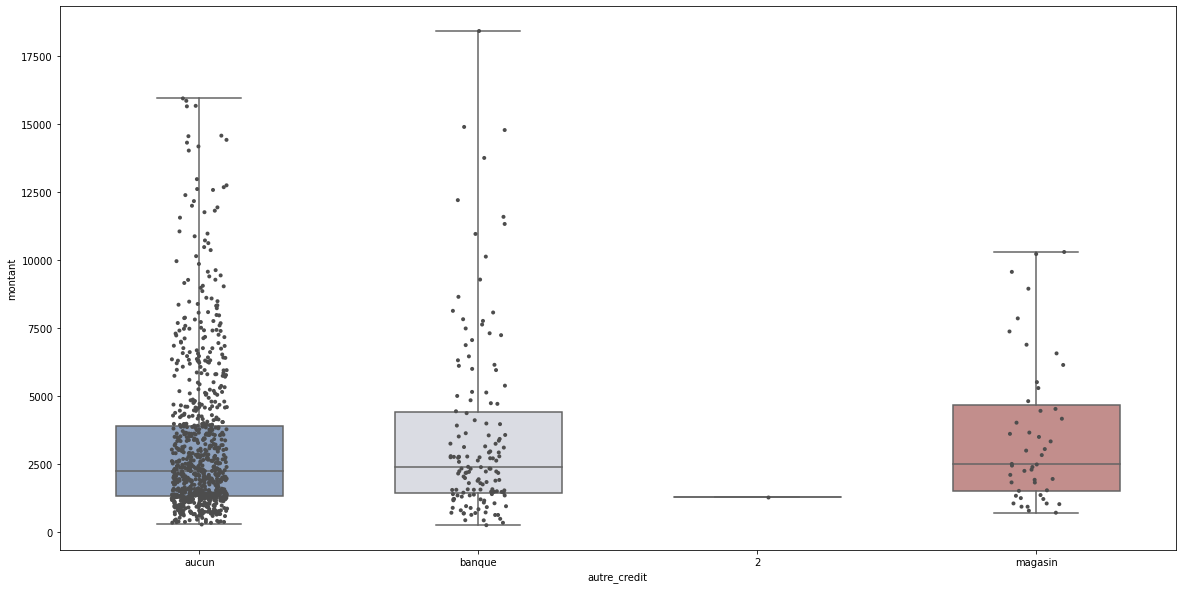

______________Conditionnal Distribution_______________


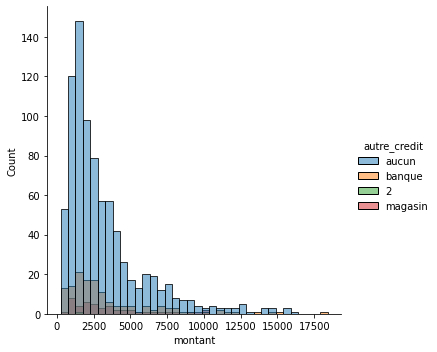

#############Response vs logement##############
_____________Pivot_______________


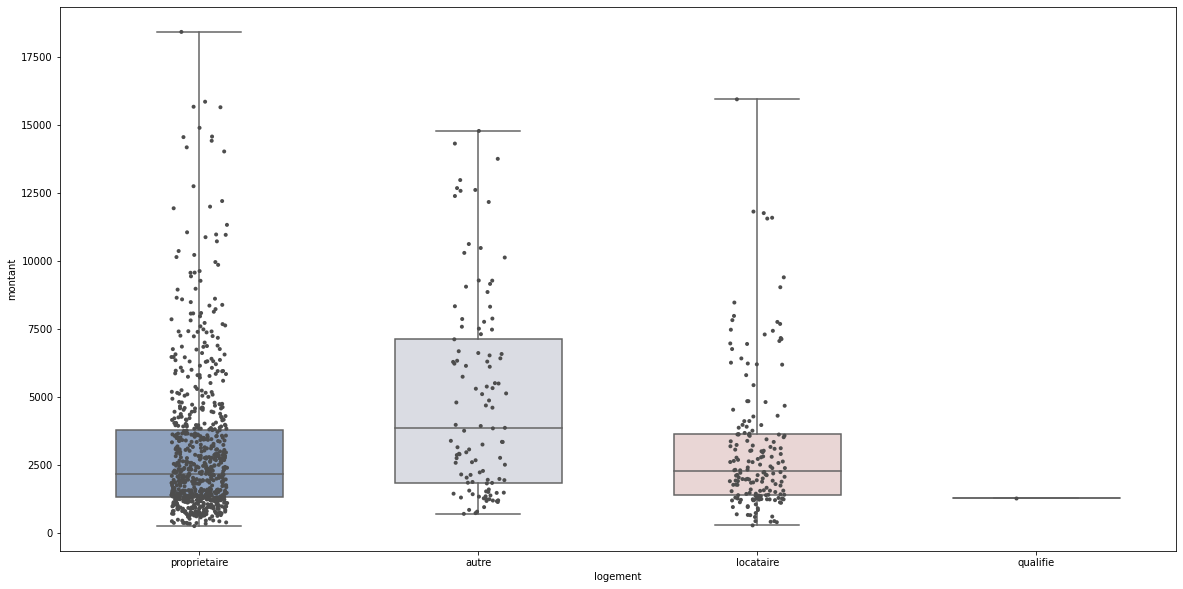

______________Conditionnal Distribution_______________


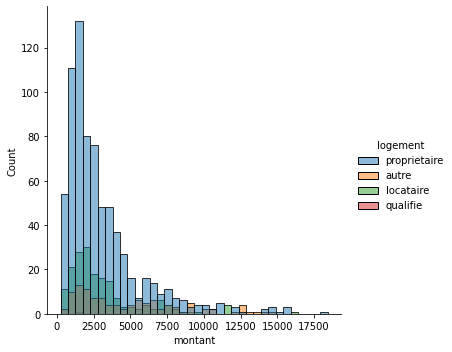

#############Response vs job##############
_____________Pivot_______________


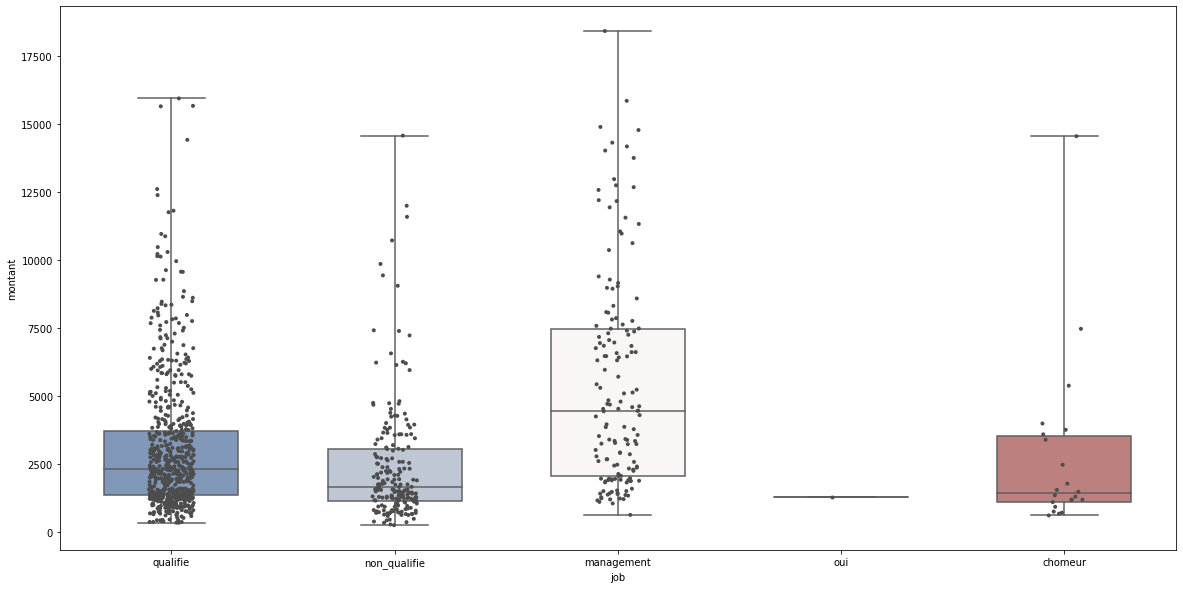

______________Conditionnal Distribution_______________


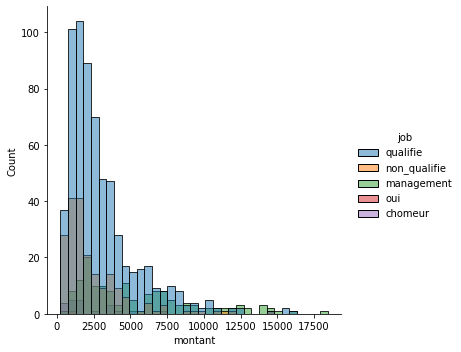

#############Response vs dependants##############
_____________Pivot_______________


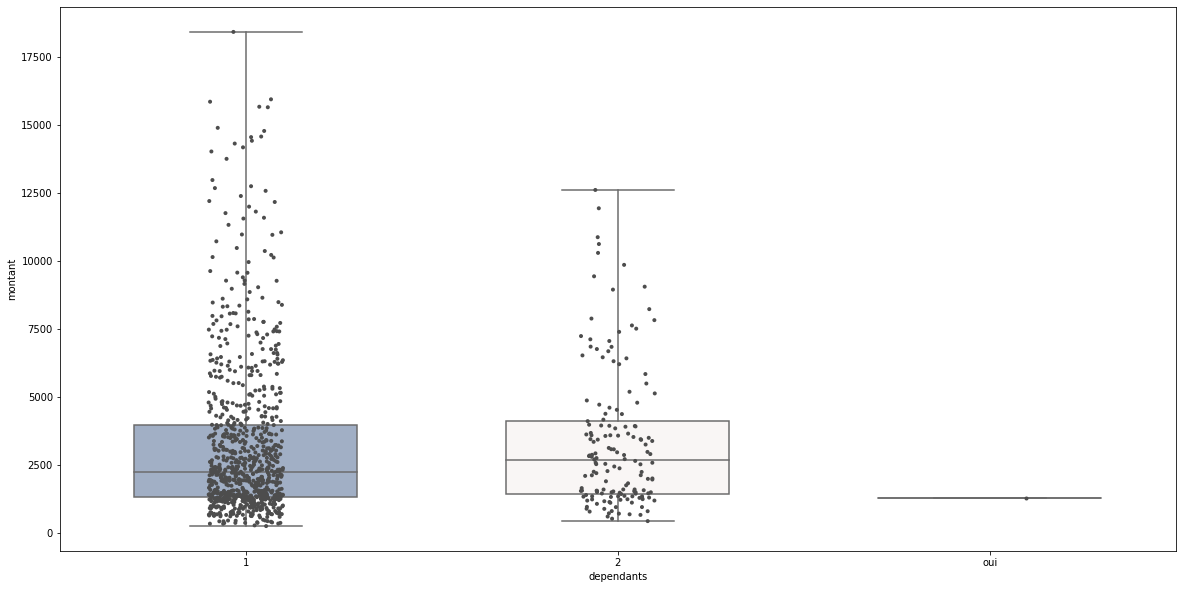

______________Conditionnal Distribution_______________


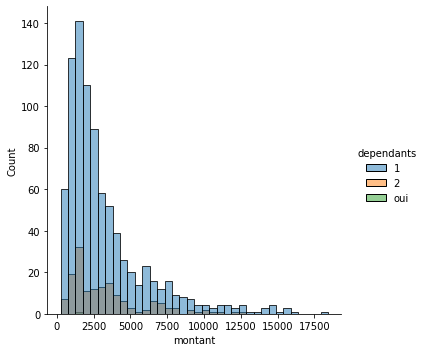

#############Response vs telephone##############
_____________Pivot_______________


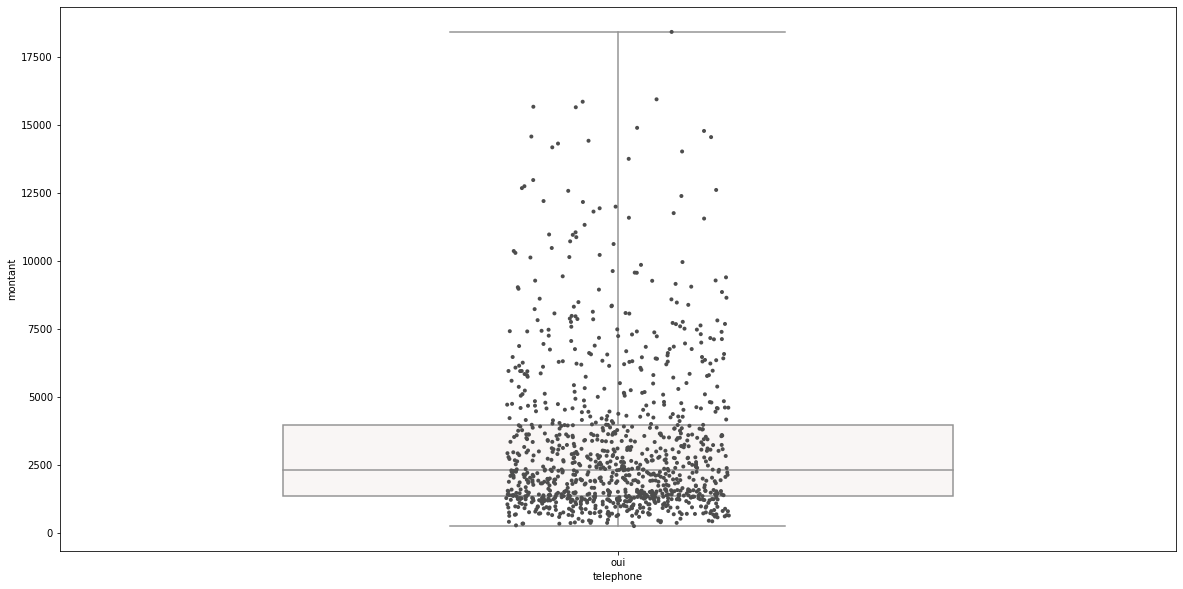

______________Conditionnal Distribution_______________


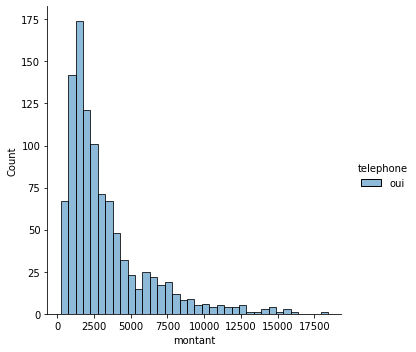

#############Response vs defaillant##############
_____________Pivot_______________


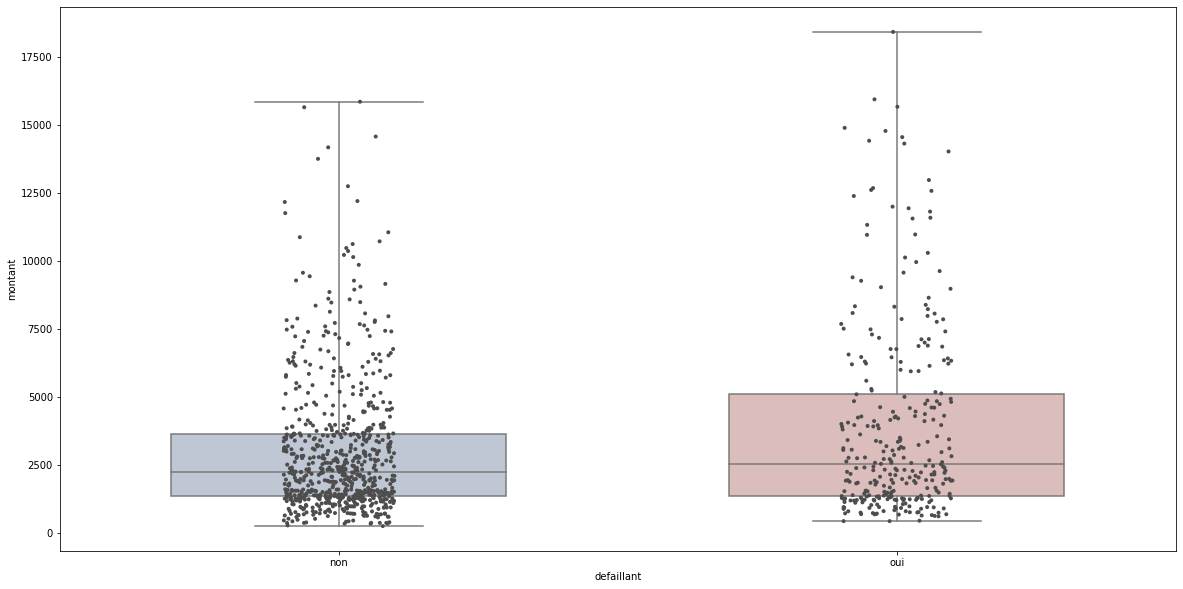

______________Conditionnal Distribution_______________


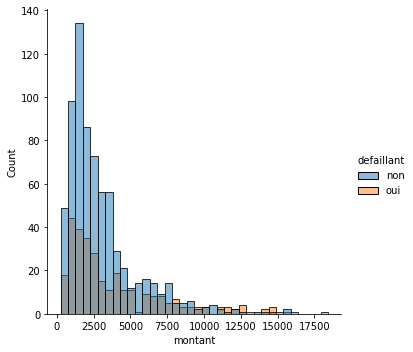

#############Response vs annees_presence_logement##############
_____________Pivot_______________


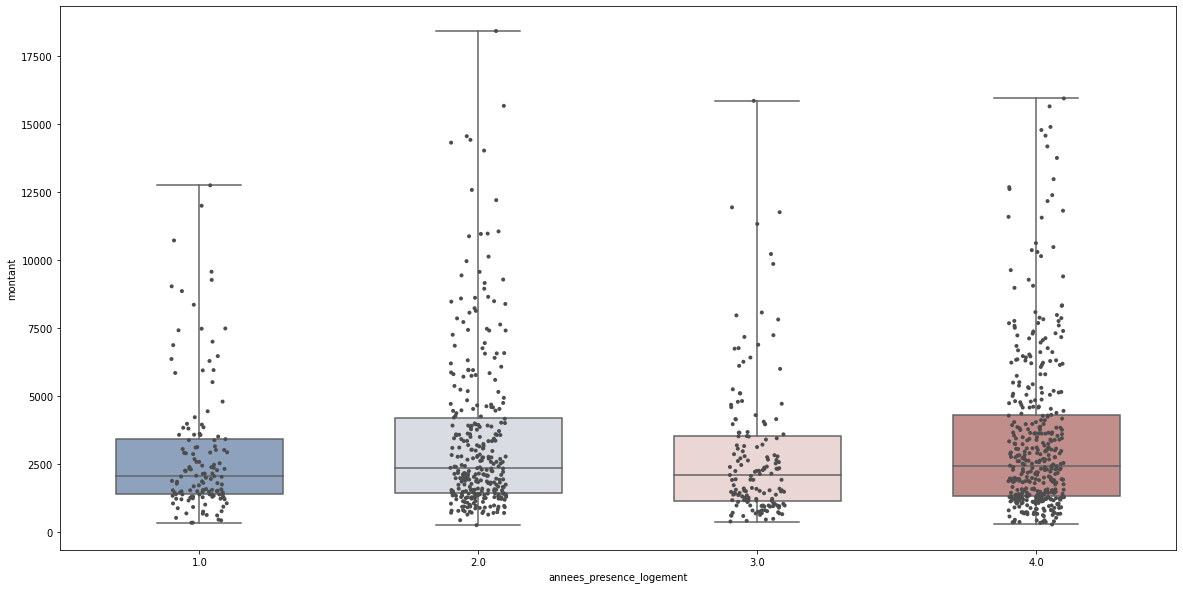

______________Conditionnal Distribution_______________


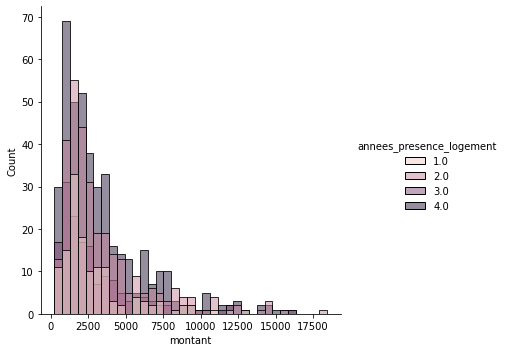

#############Response vs nbre_emprunts_actuels##############
_____________Pivot_______________


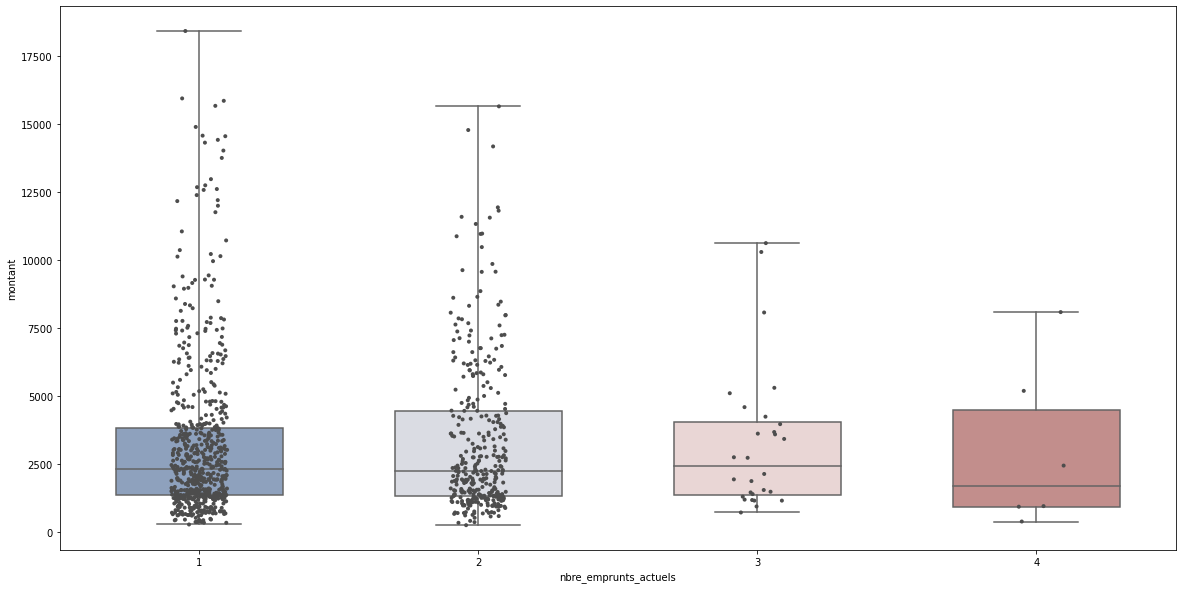

______________Conditionnal Distribution_______________


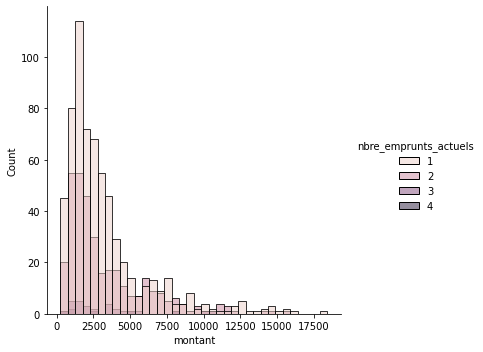

In [204]:
for x in categorical:
  target_vs_categorical(data, "montant", x)

for x in ["annees_presence_logement", "nbre_emprunts_actuels"]:
  target_vs_categorical(data, "montant", x)

- Most of these variables do not seem very discriminant : They would not be selected by Lasso.

- We must remove the too rare modalities.

## Numerical

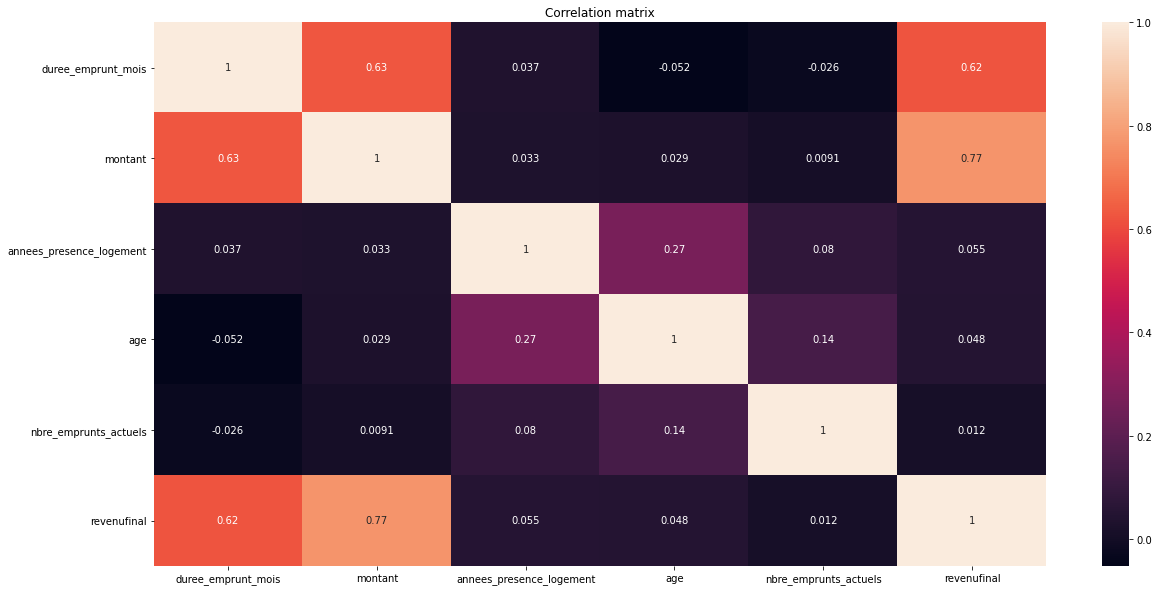

In [177]:
corrMatrix = pd.DataFrame(data[numerical].corr(method = 'pearson'))
figsize(20,10)
sns.heatmap(corrMatrix, annot=True)
title('Correlation matrix')
show()

- only positive correlations or ~0

- Strong correlations (\> 1/2) :duree_emprunt_mois / revenufinal / montant

In [209]:
def quantitative_vs_response(data, target, x):
    
      Xy = pd.DataFrame( (data[x], data[target]) ).transpose()

      print("#############Response vs " + x + "##############")

      figsize(10, 10)
      sns.kdeplot(data = Xy, 
                  x = x, 
                  y = target, 
                  fill=True, 
                  thresh=0, 
                  levels=100, 
                  cmap="mako")
      show()

#############Response vs duree_emprunt_mois##############


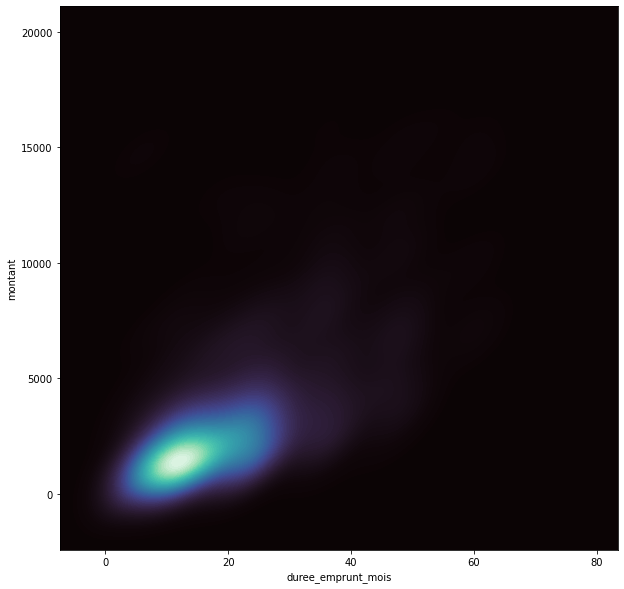

#############Response vs age##############


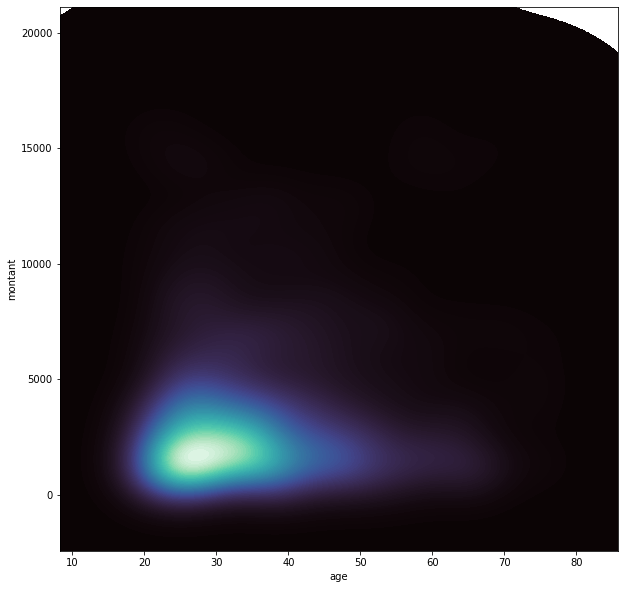

#############Response vs revenufinal##############


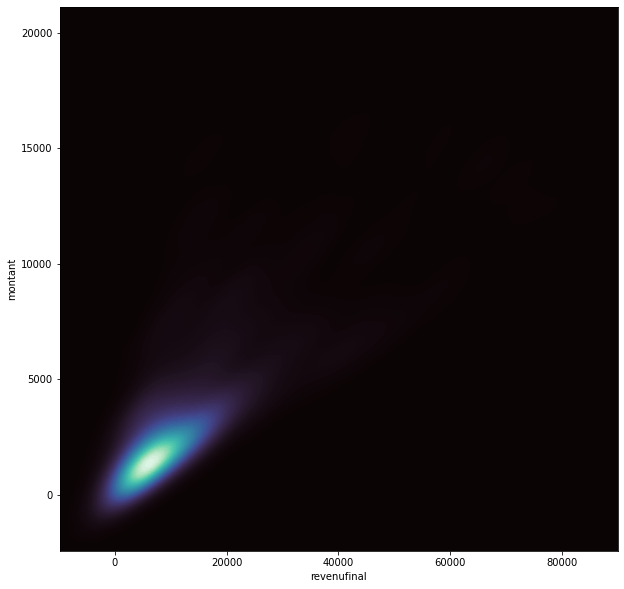

In [211]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels", "montant"]: continue
  quantitative_vs_response(data, 'montant', x)

They seem more interesting. Especially age.

# 4. Preporcessing

- train/test/split

- missing values replacement

- remove unintersting variable/modalities

- log-numerical

- dummies

- standard scaler

In [321]:
X = data.copy()
del X["montant"]
y = data["montant"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

**Missing values**

In this problem there is only a few missing values, so that it might work to replace NAs with mean/median/mode. But in practice it is a really bad idea (it reduces the variance/distance between data that we actually want to learn). We prefer an iterative Inputer.

Let's also note that we'll consider a missing value as a modality for categorical data.

In [322]:
numerical.remove("montant")

In [323]:
imputer1 = IterativeImputer(initial_strategy="mean")

imputer1.fit(X_train[numerical])

X_train[numerical] = imputer1.transform(X_train[numerical])
X_test[numerical] = imputer1.transform(X_test[numerical])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [324]:
X_train[numerical].describe()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,20.822129,2.851243,35.566883,1.411765,12306.461966
std,11.850306,1.095858,11.212916,0.574030,11294.649484
min,4.000000,1.000000,19.000000,1.000000,734.476054
25%,12.000000,2.000000,27.000000,1.000000,5123.213643
50%,18.000000,3.000000,33.000000,1.000000,8641.169211
75%,24.000000,4.000000,41.000000,2.000000,15658.446562
max,60.000000,4.000000,75.000000,4.000000,79354.527366


In [325]:
X_test[numerical].describe()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,307.000000,307.000000,307.000000,307.000000,307.000000
mean,20.651466,2.829699,35.315961,1.403909,12195.422092
std,12.522099,1.121944,11.806771,0.582746,10996.289005
min,4.000000,1.000000,19.000000,1.000000,855.840848
25%,12.000000,2.000000,26.000000,1.000000,5377.574522
50%,18.000000,3.000000,32.000000,1.000000,8509.922023
75%,24.000000,4.000000,42.000000,2.000000,15290.874467
max,72.000000,4.000000,75.000000,4.000000,68256.690578


**Dummies**

Options : drop_first = True ! (Because X must be full rank)

It will drop out telephone.

After we'll sum columns (with 0/1) and remove columns whose sum is less than 10 (too unbalanced).

In [326]:
class sk_dummies():

  def __init__(self, categorical = None, drop_n = None) :
    self.categorical = categorical
    self.drop_n = drop_n


  def fit(self, X, transform = False) :
    if self.categorical != None: 
      X2 = pd.get_dummies(X, 
                         dummy_na = True, 
                         columns = categorical, 
                         drop_first = True)
    else :
      X2 = pd.get_dummies(X, 
                          dummy_na = True, 
                          drop_first = True)
    
    if self.drop_n != None :

      to_remove = sum(X2.values, axis = 0) <= self.drop_n 
      names = list(X2.columns)

      for i in range(len(to_remove)):
        if to_remove[i]: del X2[names[i]]


    self.to_keep = list(X2.columns)
      
    if transform : return X2

  def transform(self, X):

    if self.categorical != None: 
      X2 = pd.get_dummies(X, 
                         dummy_na = True, 
                         columns = categorical, 
                         drop_first = True)
    else :
      X2 = pd.get_dummies(X, 
                          dummy_na = True, 
                          drop_first = True)
      
    for x in list(X2.columns):
      if not x in self.to_keep :
        del X2[x]
    
    for x in self.to_keep :
      if not x in list(X2.columns):
        X2[x] = zeros(X2.shape[0])

    return X2

  def fit_transform(self, X):
    return self.fit(X, transform = True)
    

In [327]:
skdummies_instance = sk_dummies(categorical, 5)
X_train = skdummies_instance.fit_transform(X_train)
X_train.shape

(714, 35)

In [328]:
X_test = skdummies_instance.transform(X_test)
X_test.shape

(307, 35)

In [329]:
X_train.head()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal,compte_courant_< 0 Euro,compte_courant_> 200 Euro,compte_courant_inconnu,historique_credit_critique,historique_credit_parfait,historique_credit_pauvre,historique_credit_tres bon,raison_auto,raison_auto0,raison_business,raison_education,raison_renonvations,compte_epargne_500 - 1000 Euro,compte_epargne_< 100 Euro,compte_epargne_> 1000 Euro,compte_epargne_inconnu,duree_emploi_4 - 7 annees,duree_emploi_< 1 annee,duree_emploi_> 7 annees,duree_emploi_chomeur,autre_credit_aucun,autre_credit_banque,autre_credit_magasin,logement_locataire,logement_proprietaire,job_management,job_non_qualifie,job_qualifie,dependants_2,defaillant_oui
436,5.0,4.0,74.0,1.0,3972.680167,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
349,10.0,1.0,37.0,1.0,5453.259292,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0
162,24.0,4.0,36.0,1.0,14886.854365,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0
884,36.0,2.0,37.0,2.0,27486.479791,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0
495,10.0,2.0,35.0,1.0,4317.722909,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0


**Take log numerical**

In [330]:
for x in numerical :
  if x in ["annees_presence_logement", "nbre_emprunts_actuels"] : continue
  else :
    X_train[x] = log(X_train[x])
    X_test[x] = log(X_test)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [331]:
y_train = log(y_train)
y_test = log(y_test)

In [332]:
X_train[numerical].describe()

,duree_emprunt_mois,annees_presence_logement,age,nbre_emprunts_actuels,revenufinal
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,2.872911,2.851243,3.526053,1.411765,9.088884
std,0.585809,1.095858,0.296460,0.574030,0.815562
min,1.386294,1.000000,2.944439,1.000000,6.599157
25%,2.484907,2.000000,3.295837,1.000000,8.541530
50%,2.890372,3.000000,3.496508,1.000000,9.064292
75%,3.178054,4.000000,3.713572,2.000000,9.658765
max,4.094345,4.000000,4.317488,4.000000,11.281681


In [363]:
standard_scaler_instance = StandardScaler()

X_train = standard_scaler_instance.fit_transform(X_train)
X_test = standard_scaler_instance.fit_transform(X_test)

- 

# 5. Linear Model

**With statsmodels** 

https://stackoverflow.com/questions/46607831/python-linear-regression-diagnostic-plots-similar-to-r

In [351]:
lm = statsmodels.api.OLS(endog=y_train, exog=X_train).fit()
influence = lm.get_influence()

res = X_train.copy()
res['resid'] = lm.resid
res['fittedvalues'] = lm.fittedvalues
res['resid_std'] = lm.resid_pearson
res['leverage'] = influence.hat_matrix_diag

print(lm.summary())


                                 OLS Regression Results                                
Dep. Variable:                montant   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              5647.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):                        0.00
Time:                        17:18:00   Log-Likelihood:                         -454.78
No. Observations:                 714   AIC:                                      979.6
Df Residuals:                     679   BIC:                                      1140.
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [352]:
def plot_diagnosis(residuals):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.style.use('seaborn')

    # Residual against fitted values.
    residuals.plot.scatter(x='fittedvalues', y='resid', ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qqplot
    statsmodels.api.qqplot(
        residuals['resid'], dist=scipy.stats.t, fit=True, line='45',
        ax=axes[0, 1], c='#4C72B0'
    )
    axes[0, 1].set_title('Normal Q-Q')

    # The scale-location plot.
    residuals.plot.scatter(x='fittedvalues', y='resid_std', ax=axes[1, 0])
    axes[1, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('Sqrt(|standardized residuals|)')
    axes[1, 0].set_title('Scale-Location')

    # Standardized residuals vs. leverage
    residuals.plot.scatter(x='leverage', y='resid_std', ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Sqrt(|standardized residuals|)')
    axes[1, 1].set_title('Residuals vs Leverage')

    tight_layout()
    show()


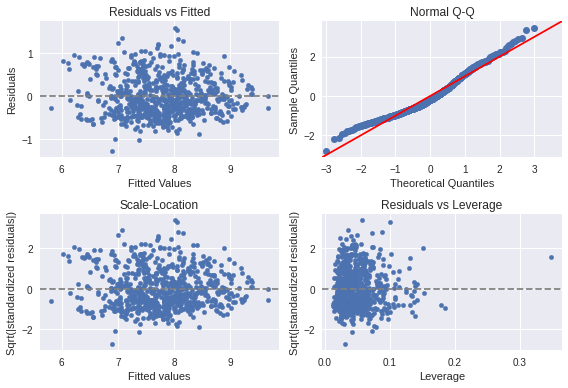

In [354]:
plot_diagnosis(res)

Residual vs fitted & scale location ok

QQ : could be better 

leverage : many points have a leverage > 1. But we do not have lots of individuals.

**Calibration score**

In [365]:
sklearn_lm = LinearRegression()
sklearn_lm.fit(X_train, y_train)
r2_score(y_train, sklearn_lm.predict(X_train))

0.6745017493745131

In [373]:
r2_score(y_train, lm.predict())

0.6726484055288584

In [374]:
def adjusted_r2(fitted_model, X, y):
  n, p = X.shape
  return 1 - ( 1 - r2_score(y, fitted_model.predict(X)) ) * (n-1)/(n - p - 1)

In [375]:
adjusted_r2(sklearn_lm, X_train, y_train)

0.6576987423363243

In [407]:
mean_squared_error(y_train, sklearn_lm.predict(X_train))

0.20811380608927924

# 6. Regularization

In [405]:
coeffs = linspace(0, 10000, 10000)
#coeffs = log(coeffs)

In [403]:
def coeffs_cv_evol(model, 
                   X_train, 
                   y_train, 
                   params,
                   plot_coeffs = True,
                   plot_mse = True,
                   plot_r2 = True):

  coeffs = []
  errorstrain = []
  r2train = []

  for a in params:
      model.set_params(alpha = a)
      model.fit(X_train, y_train)
      coeffs.append(model.coef_)
      mse_train = mean_squared_error(y_train, model.predict(X_train))
      errorstrain.append(mse_train) 
      r2_train = r2_score(y_train, model.predict(X_train))
      r2train.append(r2_train)

  
  # affichage evolution de la valeur des poids 7
  if plot_coeffs :
    figure(figsize=(20,20))
    ax = gca()
    ax.plot(params, coeffs)
    ax.set_xscale('log')
    xlabel('Param')
    ylabel('Weight')
    title('Weight~parameter')
    show()

  if plot_r2 :
    figure(figsize=(20,20))
    ax = gca()
    ax.plot(params, r2train)
    ax.set_xscale('log')
    title('R2~parameter')
    xlabel('Param')
    ylabel('r2')
    axis('tight')
    show()

  if plot_mse :
    figure(figsize=(20,20))
    ax = gca()
    ax.plot(params, errorstrain)
    ax.set_xscale('log')
    title('mse~parameter')
    xlabel('Param')
    ylabel('r2')
    axis('tight')
    show()

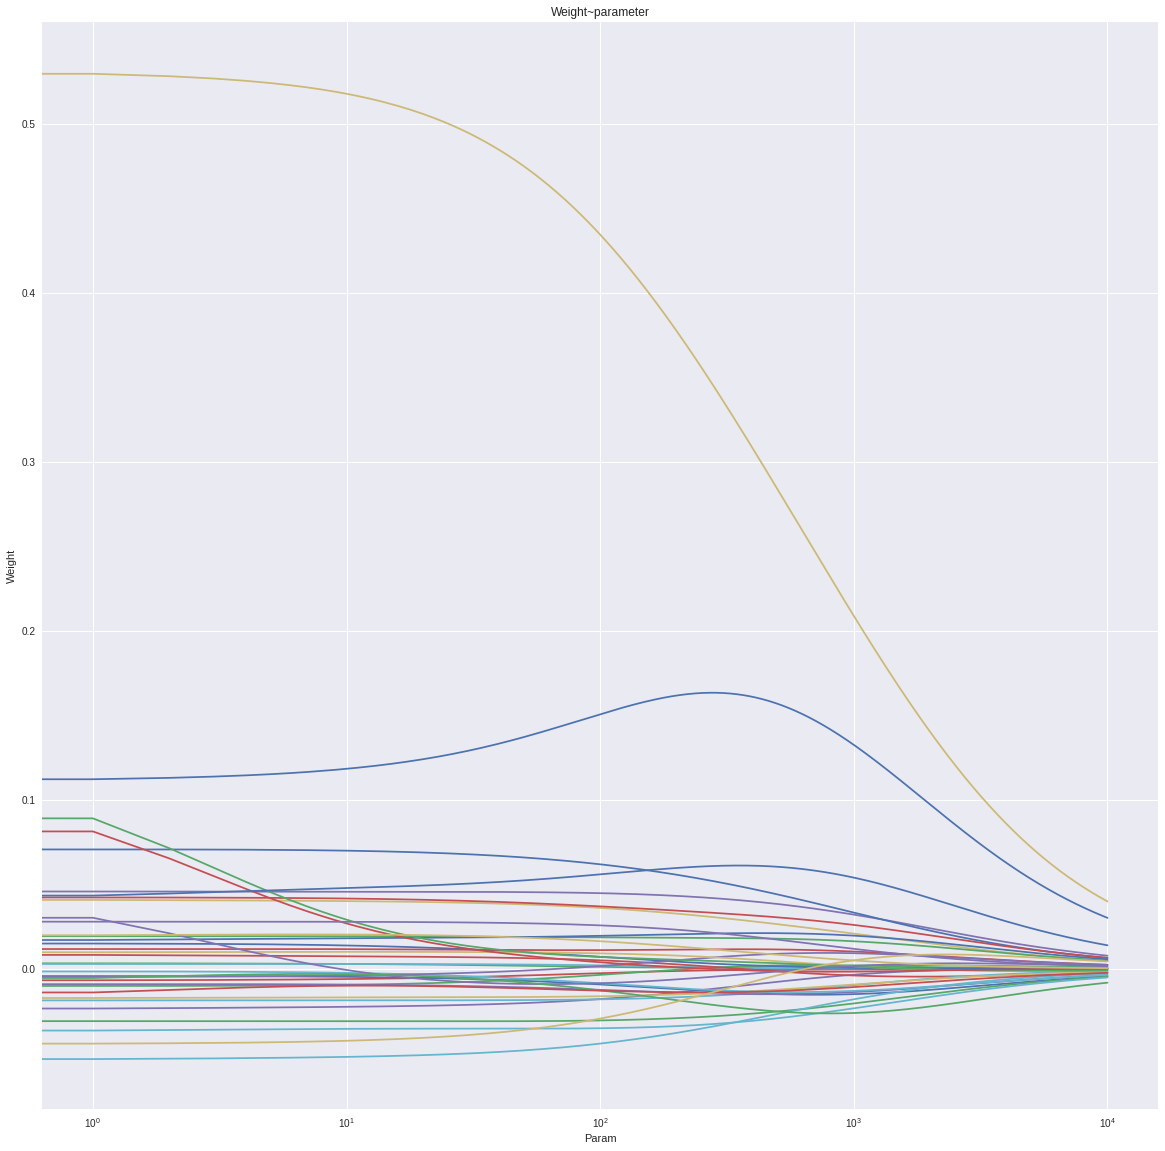

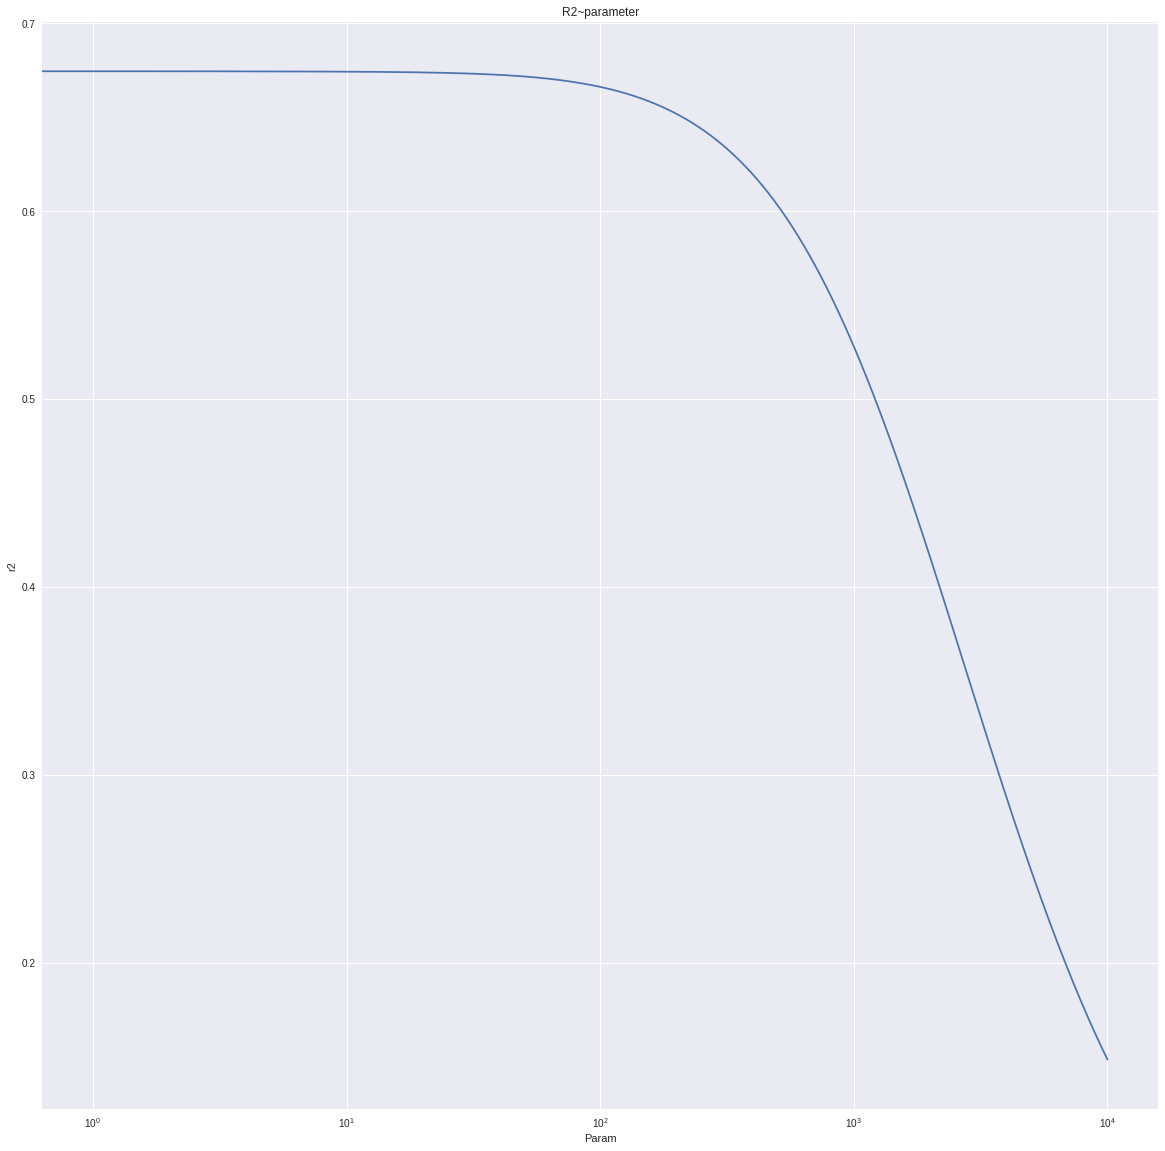

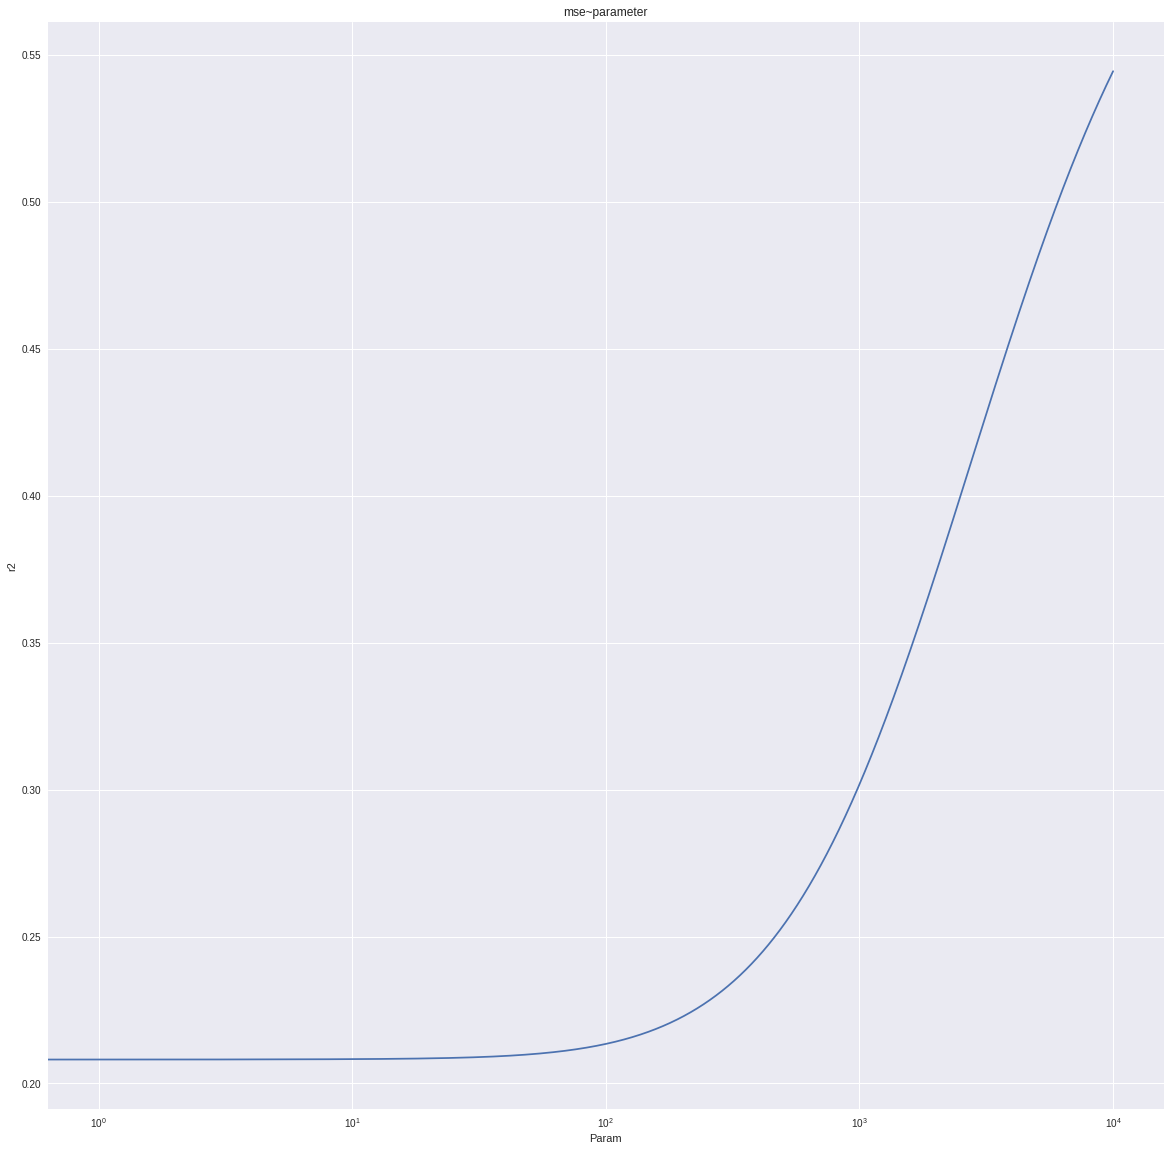

In [406]:
coeffs_cv_evol(Ridge(), X_train, y_train, coeffs)

In [408]:
ridgecv = RidgeCV(alphas = coeffs, scoring = 'neg_mean_squared_error', normalize = True, cv=10)
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([0.00000000e+00, 1.00010001e+00, 2.00020002e+00, ...,
       9.99799980e+03, 9.99899990e+03, 1.00000000e+04]),
        cv=10, fit_intercept=True, gcv_mode=None, normalize=True,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [409]:
evol = ridgecv.cbest_params

AttributeError: ignored